# InternVLA-N1 Model Inferring Notebook

This notebook is used to infer the InternVLA-N1 model's by reading images and instructions from local folders. If you'd like to test the model in real world or self-built dataset, you could follow this tutorial without large **datasets download** and **simulation environment setup** (isaac-sim or habitat). Let's start!

## 0. Preparation
### 0.0 Create Conda Environment
First, we should create a conda environment through `conda create -n internvla python=3.9` and launch the jupyter kernel using the created environment. In the following tutorial, we assume the environment name is `internvla`. 

In [ ]:
%pip install torch==2.6.0 torchvision==0.21.0 --index-url https://download.pytorch.org/whl/cu124
import torch
print(torch.__version__)

We recommend to install flash-attn2 via pre-built wheel. If you have trouble with the installation, you might also skip this installation and remove the line of `attn_implementation="flash_attention_2"` in the model initialization.

In [ ]:
!wget https://github.com/Dao-AILab/flash-attention/releases/download/v2.7.3/flash_attn-2.7.3+cu12torch2.6cxx11abiFALSE-cp39-cp39-linux_x86_64.whl
%pip install flash_attn-2.7.3+cu12torch2.6cxx11abiFALSE-cp39-cp39-linux_x86_64.whl 

In [ ]:
%pip install transformers==4.51.0 diffusers==0.31.0 accelerate==1.10.1 opencv-python==4.10.0.82 pillow==10.4.0 numpy==1.26.4 gym==0.23.1
%pip install imageio==2.37.0 imageio-ffmpeg==0.6.0 ftfy==6.3.1
%pip install scipy matplotlib
%pip install -e ../../. # install InternNav 

### 0.1 Prepare the dataset for inference

In [ ]:
!tar -xvf ../../assets/realworld_sample_data.tar.gz -C ../../assets/

### 0.2 Download checkpoint
The size of checkpoint is about 8GB.

In [ ]:
!mkdir -p checkpoints && cd checkpoints && git clone https://huggingface.co/InternRobotics/InternVLA-N1
!git lfs pull

### 0.3 Download the DepthAnything checkpoint
Download the depthanything checkpoint from [DepthAnything](https://huggingface.co/depth-anything/Depth-Anything-V2-Small/blob/14cf9f3d82acd6b6c9b43fa50b79a639a4e69c8d/depth_anything_v2_vits.pth) and move it into `InternNav/checkpoints` folder.

## 1. Import Required Libraries
Because we haven't prepared environment for other baselineas, such as CMA and RDP, we need to remove sereral lines in `internnav/agent/__init__.py`.
```bash
from internnav.agent.base import Agent
# from internnav.agent.cma_agent import CmaAgent
# from internnav.agent.rdp_agent import RdpAgent
# from internnav.agent.seq2seq_agent import Seq2SeqAgent
from internnav.agent.internvla_n1_agent import InternVLAN1Agent
```

If you meet the error about the `No module named LongCLIP (or diffusion policy)`, you should run the `git submodule update --init` in the root directory of InternNav. 

In [1]:
import sys
import os
import glob
from pathlib import Path

import numpy as np
from PIL import Image
import torch

# Add project path
project_root = Path('../../')
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / 'src/diffusion-policy'))

from internnav.agent.internvla_n1_agent_realworld import InternVLAN1AsyncAgent

PROJECT_ROOT_PATH:/home/zhenghao/InternNav


/home/zhenghao/anaconda3/envs/go/envs/internvla/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zhenghao/InternNav/scripts/notebooks/../../internnav/model/basemodel/LongCLIP/model/longclip.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging
xFormers not available
xFormers not available


## 2. Configure Parameters
Change the checkpoint path of InternVLA-N1 to the exact path in your computer. In real-world experiment, too fast inference will lead to overly close the memory intervals of the model, resulting in a large sim-to-real gap. Therefore, we use an argument `plan_step_gap` to make the model only infer every `plan_step_gap` frames when outputing trajectories. 

In [2]:
class Args:
    def __init__(self):
        self.device = "cuda:0"
        self.model_path = "../../checkpoints/InternVLA-N1"
        self.resize_w = 384
        self.resize_h = 384
        self.num_history = 8
        self.camera_intrinsic = np.array([
            [386.5, 0.0, 328.9, 0.0],
            [0.0, 386.5, 244.0, 0.0],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0]
        ])
        self.plan_step_gap = 8

args = Args()
print(f"Model path: {args.model_path}")
print(f"Device: {args.device}")
print(f"Image size: {args.resize_w}x{args.resize_h}")
print(f"History frames: {args.num_history}")

Model path: ../../checkpoints/InternVLA-N1
Device: cuda:0
Image size: 384x384
History frames: 8


## 3. Initialize Agent
Load the InternVLA-N1 model and initialize the agent. If you meet error about transformers, please check that the `flash_attn` and `accelerate` is correctly installed.

In [3]:
print("Loading model...")
agent = InternVLAN1AsyncAgent(args)

# Warm up model
print("Warming up model...")
dummy_rgb = np.zeros((480, 640, 3), dtype=np.uint8)
dummy_depth = np.zeros((480, 640), dtype=np.float32)
dummy_pose = np.eye(4)
agent.reset()
agent.step(dummy_rgb, dummy_depth, dummy_pose, "hello", intrinsic=args.camera_intrinsic)
print("Model loaded successfully!")

You are using a model of type qwen2_5_vl to instantiate a model of type internvla_n1. This is not supported for all configurations of models and can yield errors.


Loading model...
args.model_path../../checkpoints/InternVLA-N1
Loading checkpoint from /home/zhenghao/InternNav/checkpoints/depth_anything_v2_vits.pth, current working directory: /home/zhenghao/InternNav


/home/zhenghao/anaconda3/envs/go/envs/internvla/lib/python3.9/site-packages/torch/nn/modules/module.py:2397: UserWarning: for pretrained.cls_token: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/zhenghao/anaconda3/envs/go/envs/internvla/lib/python3.9/site-packages/torch/nn/modules/module.py:2397: UserWarning: for pretrained.pos_embed: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/zhenghao/anaconda3/envs/go/envs/internvla/lib/python3.9/site-packages/torch/nn/modules/module.py:2397: UserWarning: for pretrained.patch

Loading navdp model: NavDP_Policy_DPT_CriticSum_DAT
Pretrained: None
No pretrained weights provided, initializing randomly.


Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]
Some weights of the model checkpoint at ../../checkpoints/InternVLA-N1 were not used when initializing InternVLAN1ForCausalLM: ['model.navdp.rgbd_encoder.depth_model.mask_token', 'model.navdp.rgbd_encoder.rgb_model.mask_token']
- This IS expected if you are initializing InternVLAN1ForCausalLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing InternVLAN1ForCausalLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will resu

Warming up model...


/home/zhenghao/anaconda3/envs/go/envs/internvla/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/zhenghao/anaconda3/envs/go/envs/internvla/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.001` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/zhenghao/anaconda3/envs/go/envs/internvla/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warning

output 1  →→→→ cost: 1.1977059841156006s
Model loaded successfully!


## 4. Configure Test Data Path
Now we used a pre-collected real-world dataset to test our model. The images were captured through a Unitree Go2 robot mounted with a realsense D455. You could freely change the dataset to your own dataset and an `instruction.txt` file. Note that the `InternVLA-N1` model use depth image inputs for S1 model, but we forgot recording the depth image in real-world dataset. If you want to build your own dataset, please record **both the aligned depth and rgb images**. 

In [4]:
# Configure data directory (single scene per folder)
scene_dir = '../../assets/realworld_sample_data1'

# Check if instruction file exists
instruction_path = os.path.join(scene_dir, 'instruction.txt')
if not os.path.exists(instruction_path):
    print(f"Error: instruction.txt not found in {scene_dir}")
else:
    print(f"Scene directory: {scene_dir}")
    
    # Read instruction
    with open(instruction_path, 'r') as f:
        instruction = f.read().strip()
    print(f"Instruction: {instruction}")
    
    # Get all debug_raw images
    rgb_paths = sorted(glob.glob(os.path.join(scene_dir, 'debug_raw_*.jpg')))
    print(f"\nFound {len(rgb_paths)} images")
    # Show first few image names
    print("\nFirst 5 images:")
    for i, path in enumerate(rgb_paths[:5]):
        print(f"  {i+1}. {os.path.basename(path)}")

Scene directory: ../../assets/realworld_sample_data1
Instruction: Turn around and walk out of this office. Turn towards your slight right at the chair. Move forward to the walkway and go near the red bin. You can see an open door on your right side, go inside the open door. Stop at the computer monitor.

Found 152 images

First 5 images:
  1. debug_raw_0000.jpg
  2. debug_raw_0001.jpg
  3. debug_raw_0002.jpg
  4. debug_raw_0003.jpg
  5. debug_raw_0004.jpg


Now add some visualization function for the model.

In [5]:
from PIL import Image, ImageDraw, ImageFont
import cv2

def annotate_image(idx, image, llm_output, trajectory, pixel_goal, output_dir):
    image = Image.fromarray(image)#.save(f'rgb_{idx}.png')
    draw = ImageDraw.Draw(image)
    font_size = 20
    font = ImageFont.truetype("DejaVuSansMono.ttf", font_size)
    text_content = []
    text_content.append(f"Frame    Id  : {idx}")
    text_content.append(f"Actions      : {llm_output}" )
    max_width = 0
    total_height = 0
    for line in text_content:
        bbox = draw.textbbox((0, 0), line, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = 26
        max_width = max(max_width, text_width)
        total_height += text_height

    padding = 10
    box_x, box_y = 10, 10
    box_width = max_width + 2 * padding
    box_height = total_height + 2 * padding

    draw.rectangle([box_x, box_y, box_x + box_width, box_y + box_height], fill='black')

    text_color = 'white'
    y_position = box_y + padding
    
    for line in text_content:
        draw.text((box_x + padding, y_position), line, fill=text_color, font=font)
        bbox = draw.textbbox((0, 0), line, font=font)
        text_height = 26
        y_position += text_height
    image = np.array(image)
    
    # Draw trajectory visualization in the top-right corner using matplotlib
    if trajectory is not None and len(trajectory) > 0:
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
        
        img_height, img_width = image.shape[:2]
        
        # Window parameters
        window_size = 200  # Window size in pixels
        window_margin = 0  # Margin from edge
        window_x = img_width - window_size - window_margin
        window_y = window_margin
        
        # Extract trajectory points
        traj_points = []
        for point in trajectory:
            if isinstance(point, (list, tuple, np.ndarray)) and len(point) >= 2:
                traj_points.append([float(point[0]), float(point[1])])
        
        if len(traj_points) > 0:
            traj_array = np.array(traj_points)
            x_coords = traj_array[:, 0]
            y_coords = traj_array[:, 1]
            
            # Create matplotlib figure
            fig, ax = plt.subplots(figsize=(2, 2), dpi=100)
            fig.patch.set_alpha(0.6)  # Semi-transparent background
            fig.patch.set_facecolor('gray')
            ax.set_facecolor('lightgray')
            
            # Plot trajectory
            # Coordinate system: x-axis points up, y-axis points left
            # Origin at bottom center
            ax.plot(y_coords, x_coords, 'b-', linewidth=2, label='Trajectory')
            
            # Mark start point (green) and end point (red)
            ax.plot(y_coords[0], x_coords[0], 'go', markersize=6, label='Start')
            ax.plot(y_coords[-1], x_coords[-1], 'ro', markersize=6, label='End')
            
            # Mark origin
            ax.plot(0, 0, 'w+', markersize=10, markeredgewidth=2, label='Origin')
            
            # Set axis labels
            ax.set_xlabel('Y (left +)', fontsize=8)
            ax.set_ylabel('X (up +)', fontsize=8)
            ax.invert_xaxis()
            ax.tick_params(labelsize=6)
            ax.grid(True, alpha=0.3, linewidth=0.5)
            
            # Set equal aspect ratio
            ax.set_aspect('equal', adjustable='box')
            
            # Add legend
            ax.legend(fontsize=6, loc='upper right')
            
            # Adjust layout
            plt.tight_layout(pad=0.3)
            
            # Convert matplotlib figure to numpy array
            canvas = FigureCanvasAgg(fig)
            canvas.draw()
            plot_img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
            plot_img = plot_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close(fig)
            
            # Resize plot to fit window
            plot_img = cv2.resize(plot_img, (window_size, window_size))
            
            # Overlay plot on image
            image[window_y:window_y+window_size, window_x:window_x+window_size] = plot_img
    
    if pixel_goal is not None:
        cv2.circle(image, (pixel_goal[1], pixel_goal[0]), 5, (255, 0, 0), -1)
    image = Image.fromarray(image).convert('RGB')
    image.save(f'{output_dir}/rgb_{idx}_annotated.png')
    # to numpy array
    return np.array(image)

## 5. Run Model Testing
We begin to read the local images, instruction to run the model. Please make sure that the depth image is fed to the model and **the unit is in meter**. You could print the maximum value of the depth image in your real-world experiment and check the value. 

If everything goes well, the model will rotate in place at the begining. Then it generates the correct pixel goal and trajectories. The visualization results are also saved in the `save_dir` folder.

In [7]:
from tqdm import tqdm  # Add tqdm for progress bar

# Reset agent
agent.reset()
print(f"{'='*80}")
print(f"Processing scene: {os.path.basename(scene_dir)}")
print(f"Instruction: '{instruction}'")
print(f"Total images: {len(rgb_paths)}")
print(f"{'='*80}\n")

action_seq = []
look_down = False

save_dir = '../../test_data/'
os.makedirs(save_dir, exist_ok=True)

# Process each image with progress bar
for i, rgb_path in enumerate(tqdm(rgb_paths, desc="Processing Images", unit="img")):
    # Check if this is a look_down image
    look_down = ('look_down' in rgb_path)
    
    # Extract image ID from filename (e.g., debug_raw_0003.jpg -> 0003)
    basename = os.path.basename(rgb_path)
    if look_down:
        # e.g., debug_raw_0010_look_down.jpg -> 0010
        image_id = basename.replace('debug_raw_', '').replace('_look_down.jpg', '')
    else:
        # e.g., debug_raw_0003.jpg -> 0003
        image_id = basename.replace('debug_raw_', '').replace('.jpg', '')
        
    # Read RGB image
    rgb = np.asarray(Image.open(rgb_path).convert('RGB'))
    
    # Create dummy depth image (not available in test data)
    # !Note You must full in depth to model
    depth = np.zeros((rgb.shape[0], rgb.shape[1]), dtype=np.float32)
    
    # Create dummy camera pose
    camera_pose = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    
    # Run model or just save image
    # print(f"[{i+1}/{len(rgb_paths)}] Running model inference: {os.path.basename(rgb_path)}")
    dual_sys_output = agent.step(
        rgb, 
        depth, 
        camera_pose, 
        instruction, 
        intrinsic=args.camera_intrinsic,
        look_down=look_down
    )
    
    # Print output results
    if dual_sys_output.output_action is not None and dual_sys_output.output_action != []:
        print(f"  Output action: {dual_sys_output.output_action}")
        # action_seq.extend(s2_output.output_action)
    else:
        print(f"output_trajectory: {dual_sys_output.output_trajectory.tolist()}")
        if dual_sys_output.output_pixel is not None:
            print(f"output_pixel: {dual_sys_output.output_pixel}")
            annotate_image(image_id, rgb, 'traj', dual_sys_output.output_trajectory.tolist(), dual_sys_output.output_pixel, save_dir)

print(f"\nScene {os.path.basename(scene_dir)} completed!")


Processing scene: realworld_sample_data1
Instruction: 'Turn around and walk out of this office. Turn towards your slight right at the chair. Move forward to the walkway and go near the red bin. You can see an open door on your right side, go inside the open door. Stop at the computer monitor.'
Total images: 152



Processing Images:   1%|          | 1/152 [00:00<00:27,  5.51img/s]

output 1  →→→→ cost: 0.15460562705993652s
  Output action: [3, 3, 3, 3]


Processing Images:   1%|▏         | 2/152 [00:00<00:29,  5.17img/s]

output 2  →→→→ cost: 0.18497085571289062s
  Output action: [3, 3, 3, 3]


Processing Images:   2%|▏         | 3/152 [00:00<00:31,  4.68img/s]

output 3  →→→→ cost: 0.2146461009979248s
  Output action: [3, 3, 3, 3]


Processing Images:   3%|▎         | 4/152 [00:00<00:35,  4.18img/s]

output 4  →→→→ cost: 0.24994301795959473s
  Output action: [3, 3, 3, 3]


Processing Images:   3%|▎         | 5/152 [00:01<00:39,  3.76img/s]

output 5  →→→→ cost: 0.2816660404205322s
  Output action: [3, 3, 3, 3]


Processing Images:   4%|▍         | 6/152 [00:01<00:43,  3.38img/s]

output 6  →→→→ cost: 0.3168332576751709s
  Output action: [3, 3, 3, 3]


Processing Images:   5%|▍         | 7/152 [00:01<00:47,  3.05img/s]

output 7  →→→→ cost: 0.3510153293609619s
  Output action: [3, 3, 3, 3]


Processing Images:   5%|▌         | 8/152 [00:02<00:52,  2.76img/s]

output 8  →→→→ cost: 0.38778066635131836s
  Output action: [3, 3, 3, 3]


Processing Images:   6%|▌         | 9/152 [00:02<00:57,  2.51img/s]

output 9  →→→→ cost: 0.42731523513793945s
  Output action: [3, 3, 3, 3]


Processing Images:   7%|▋         | 10/152 [00:03<00:57,  2.49img/s]

output 10  ↓ cost: 0.35747480392456055s
  Output action: [5]


Processing Images:   7%|▋         | 11/152 [00:03<00:56,  2.48img/s]

output 11  ↓ cost: 0.3585169315338135s
  Output action: [5]
output 11  460 210 cost: 0.3694918155670166s


/tmp/ipykernel_182830/3632390943.py:99: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  plot_img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
Processing Images:   9%|▊         | 13/152 [00:04<01:00,  2.28img/s]

output_trajectory: [[0.0, 0.0], [0.08206462860107422, -0.007764875888824463], [0.1603967547416687, -0.017518848180770874], [0.21564501523971558, -0.028940349817276], [0.24642519652843475, -0.0394526869058609], [0.2795782834291458, -0.05320165306329727], [0.30585818737745285, -0.06729898601770401], [0.328582264482975, -0.08580391108989716], [0.34528932720422745, -0.09941873699426651], [0.36219146847724915, -0.1108430027961731], [0.3801117083057761, -0.11928066611289978], [0.3982652770355344, -0.12586988508701324], [0.4168904246762395, -0.13681305944919586], [0.43328451830893755, -0.1495106965303421], [0.4523786464706063, -0.16000984609127045], [0.46796806063503027, -0.16644375026226044], [0.47983360942453146, -0.16687088459730148], [0.4891604697331786, -0.16596288233995438], [0.49636612739413977, -0.16413374990224838], [0.5036515137180686, -0.16342833638191223], [0.5105225509032607, -0.1638360619544983], [0.5138971721753478, -0.1637689657509327], [0.5170979117974639, -0.1629609726369381

Processing Images:  10%|▉         | 15/152 [00:05<00:37,  3.67img/s]

output_trajectory: [[0.0, 0.0], [0.08896291255950928, 0.03325462341308594], [0.17332589626312256, 0.07562169432640076], [0.24235236644744873, 0.12773799896240234], [0.30019430816173553, 0.18676885962486267], [0.3574628084897995, 0.2487282007932663], [0.4073306806385517, 0.31193651258945465], [0.4556204564869404, 0.3793763369321823], [0.4892435111105442, 0.42688919603824615], [0.5243874229490757, 0.47447022050619125], [0.5556797720491886, 0.516740046441555], [0.5749381966888905, 0.5515662059187889], [0.5937580652534962, 0.5850791111588478], [0.6085326559841633, 0.6092363819479942], [0.6264178045094013, 0.637223906815052], [0.6429545022547245, 0.6618223823606968], [0.6491997726261616, 0.6758225075900555], [0.6545021124184132, 0.6853672377765179], [0.658972654491663, 0.6929703243076801], [0.6654306687414646, 0.7027129270136356], [0.6683475561439991, 0.7083359248936176], [0.6740777529776096, 0.7173211015760899], [0.6786163039505482, 0.7235037721693516], [0.6800472922623158, 0.7273463234305

Processing Images:  11%|█         | 17/152 [00:05<00:26,  5.17img/s]

output_trajectory: [[0.0, 0.0], [0.0903158187866211, 0.024283409118652344], [0.1796109676361084, 0.05936390161514282], [0.25419044494628906, 0.11489087343215942], [0.32311826944351196, 0.18469813466072083], [0.38240689039230347, 0.2575400173664093], [0.4287610650062561, 0.3227015435695648], [0.47170013189315796, 0.39206305146217346], [0.5006455183029175, 0.44285300374031067], [0.5249829292297363, 0.4895607531070709], [0.545905351638794, 0.5293385982513428], [0.5603727102279663, 0.5575006902217865], [0.5755469799041748, 0.5875577479600906], [0.5860227942466736, 0.6098276078701019], [0.5978347063064575, 0.6337366327643394], [0.6079462170600891, 0.6526629850268364], [0.6133972108364105, 0.6681862995028496], [0.6181798577308655, 0.6857788637280464], [0.6217036247253418, 0.6924545913934708], [0.6250307559967041, 0.7023997427895665], [0.6276907026767731, 0.7104773493483663], [0.627867117524147, 0.7159244837239385], [0.627424493432045, 0.7230749176815152], [0.6273174062371254, 0.7233557896688

Processing Images:  12%|█▎        | 19/152 [00:05<00:20,  6.51img/s]

output_trajectory: [[0.0, 0.0], [0.0944061279296875, 0.028224468231201172], [0.18280529975891113, 0.06426167488098145], [0.2570033073425293, 0.11393672227859497], [0.32694971561431885, 0.17736923694610596], [0.39157354831695557, 0.24507343769073486], [0.43025653064250946, 0.2953560948371887], [0.47133882343769073, 0.3475631773471832], [0.5090475231409073, 0.39156927168369293], [0.5496722906827927, 0.4413151890039444], [0.5891883820295334, 0.4865781143307686], [0.615230068564415, 0.5147527679800987], [0.6424275785684586, 0.5453126057982445], [0.662743404507637, 0.5679178014397621], [0.6838447004556656, 0.5957482382655144], [0.7003580778837204, 0.616478718817234], [0.7048798650503159, 0.6244436874985695], [0.7100839763879776, 0.6322135105729103], [0.7120817601680756, 0.635107971727848], [0.7143052518367767, 0.6383689418435097], [0.7153697069734335, 0.6399268209934235], [0.7167079243808985, 0.641086034476757], [0.7168738786131144, 0.6416251882910728], [0.716672832146287, 0.641353763639926

Processing Images:  14%|█▍        | 21/152 [00:06<00:45,  2.86img/s]

output_trajectory: [[0.0, 0.0], [0.07936584949493408, -0.003955453634262085], [0.15886294841766357, -0.009126856923103333], [0.2098279595375061, -0.012955859303474426], [0.2400328367948532, -0.015113689005374908], [0.2668100893497467, -0.017405487596988678], [0.2789551392197609, -0.01965329796075821], [0.2937653735280037, -0.018727153539657593], [0.3068127706646919, -0.016763754189014435], [0.31740549951791763, -0.013710521161556244], [0.3231775835156441, -0.01197456568479538], [0.32565804570913315, -0.006574980914592743], [0.3284187838435173, -0.0016428455710411072], [0.3308427110314369, 0.004129275679588318], [0.334370993077755, 0.008387275040149689], [0.3377147540450096, 0.015949256718158722], [0.33928321301937103, 0.02191043645143509], [0.34132733941078186, 0.02828938513994217], [0.3427143134176731, 0.0321955606341362], [0.34382784366607666, 0.03518080711364746], [0.34469930827617645, 0.03763128072023392], [0.34592923149466515, 0.04031740874052048], [0.3462654612958431, 0.043273158

Processing Images:  15%|█▌        | 23/152 [00:06<00:30,  4.29img/s]

output_trajectory: [[0.0, 0.0], [0.08267807960510254, -0.0008122250437736511], [0.1596207618713379, -0.004357136785984039], [0.20949029922485352, -0.0008200183510780334], [0.23125392198562622, 0.00802668184041977], [0.2533458322286606, 0.01644601672887802], [0.2592732757329941, 0.020862169563770294], [0.26674680411815643, 0.02631693333387375], [0.27347269654273987, 0.027436643838882446], [0.2770484536886215, 0.02625995222479105], [0.2771781086921692, 0.024638657458126545], [0.27766409516334534, 0.023131285794079304], [0.27584028244018555, 0.019926209934055805], [0.27516481280326843, 0.01785448659211397], [0.2749745100736618, 0.017505553551018238], [0.27469900250434875, 0.01732954103499651], [0.27473410218954086, 0.017202322371304035], [0.27437063306570053, 0.01682471204549074], [0.27434840984642506, 0.016580660827457905], [0.27420436032116413, 0.016352632082998753], [0.27421254105865955, 0.016126655973494053], [0.27417405135929585, 0.01581758353859186], [0.27391387708485126, 0.01553203

Processing Images:  16%|█▋        | 25/152 [00:07<00:22,  5.77img/s]

output_trajectory: [[0.0, 0.0], [0.07628083229064941, 0.0005436241626739502], [0.15536224842071533, -0.0008700639009475708], [0.20432138442993164, -0.0073023587465286255], [0.2277337685227394, -0.011263862252235413], [0.24790676683187485, -0.010835077613592148], [0.2640644758939743, -0.00483187660574913], [0.2756514698266983, -0.0019396506249904633], [0.2846900373697281, -0.0010755397379398346], [0.28930631279945374, -0.004301246255636215], [0.2909494787454605, -0.006215404719114304], [0.29187198728322983, -0.002888444811105728], [0.2922663316130638, -0.0007493831217288971], [0.2929898127913475, 0.0023893825709819794], [0.2940085306763649, 0.005636956542730331], [0.2955375388264656, 0.01153464987874031], [0.2963053248822689, 0.01665375754237175], [0.2979706786572933, 0.02197500690817833], [0.29812042973935604, 0.02466350421309471], [0.29715003445744514, 0.027559587731957436], [0.2966049276292324, 0.029019908979535103], [0.29650722071528435, 0.028570668771862984], [0.2958500199019909, 0

Processing Images:  18%|█▊        | 27/152 [00:07<00:19,  6.49img/s]

output_trajectory: [[0.0, 0.0], [0.07228714227676392, -0.008722066879272461], [0.1397528052330017, -0.017433688044548035], [0.1849387288093567, -0.023640260100364685], [0.21599242091178894, -0.02750621736049652], [0.23918454349040985, -0.03467375785112381], [0.24729426577687263, -0.04110775142908096], [0.2527329809963703, -0.04999887943267822], [0.25688885524868965, -0.05641777813434601], [0.2634226866066456, -0.06029306352138519], [0.26845841482281685, -0.06477872282266617], [0.27350105345249176, -0.06987569481134415], [0.2768079340457916, -0.07567089423537254], [0.28047721087932587, -0.07973048463463783], [0.2874315679073334, -0.08515721745789051], [0.29380740970373154, -0.08896617032587528], [0.299936942756176, -0.09090722352266312], [0.3029337003827095, -0.09147196635603905], [0.3032277040183544, -0.0917176604270935], [0.30302342399954796, -0.09188476204872131], [0.3028516210615635, -0.09217482432723045], [0.302820548415184, -0.09272235259413719], [0.30266304314136505, -0.092963494

Processing Images:  19%|█▉        | 29/152 [00:08<00:46,  2.65img/s]

output_trajectory: [[0.0, 0.0], [0.09434366226196289, 0.0049974918365478516], [0.1901841163635254, 0.006140351295471191], [0.26694154739379883, 0.018338322639465332], [0.327605664730072, 0.03448796272277832], [0.38453020341694355, 0.059321463108062744], [0.4332426209002733, 0.09223386645317078], [0.47712561674416065, 0.1280089020729065], [0.516861280426383, 0.1681775152683258], [0.5516095738857985, 0.20043537765741348], [0.5874352101236582, 0.229647446423769], [0.6206500958651304, 0.25604671612381935], [0.6548286806792021, 0.27727003768086433], [0.6822456400841475, 0.2933642715215683], [0.7099313195794821, 0.3092968314886093], [0.736206566914916, 0.3234260007739067], [0.7651679050177336, 0.33481859415769577], [0.7868319489061832, 0.34130340069532394], [0.8066480793058872, 0.34827299416065216], [0.8236441276967525, 0.35122711956501007], [0.8395869135856628, 0.35384007543325424], [0.8533724546432495, 0.3574672266840935], [0.8667693063616753, 0.359575055539608], [0.8717179149389267, 0.360

Processing Images:  20%|██        | 31/152 [00:09<00:29,  4.08img/s]

output_trajectory: [[0.0, 0.0], [0.0992584228515625, 0.011339306831359863], [0.203277587890625, 0.025401532649993896], [0.30104827880859375, 0.03701019287109375], [0.3927822411060333, 0.04262489080429077], [0.48824504017829895, 0.03686469793319702], [0.5784101784229279, 0.02200981229543686], [0.6697023212909698, -0.0017061606049537659], [0.7610600292682648, -0.034099020063877106], [0.8490020334720612, -0.07558349519968033], [0.9337210655212402, -0.12238041311502457], [1.0063158720731735, -0.16568658500909805], [1.078111857175827, -0.2124711349606514], [1.1478052288293839, -0.2595495656132698], [1.203394278883934, -0.29877784848213196], [1.2557583898305893, -0.33491963148117065], [1.3063960075378418, -0.3663576729595661], [1.3528098613023758, -0.39566604420542717], [1.3898782506585121, -0.4169555567204952], [1.42564906924963, -0.4378153048455715], [1.4600508585572243, -0.4591224752366543], [1.4854029789566994, -0.47563834115862846], [1.5084838196635246, -0.49339432641863823], [1.5181994

Processing Images:  22%|██▏       | 33/152 [00:09<00:21,  5.60img/s]

output_trajectory: [[0.0, 0.0], [0.0965728759765625, 0.018066585063934326], [0.1985626220703125, 0.03735238313674927], [0.2929229736328125, 0.060441792011260986], [0.38986754417419434, 0.08404487371444702], [0.48431462049484253, 0.10250991582870483], [0.5727449655532837, 0.11448809504508972], [0.6547254025936127, 0.1185394823551178], [0.7288919985294342, 0.1125560775399208], [0.7930431067943573, 0.0997757688164711], [0.8548126369714737, 0.08233258873224258], [0.9113566428422928, 0.058949150145053864], [0.9667873233556747, 0.027977891266345978], [1.0182988792657852, -0.005194775760173798], [1.06712781265378, -0.03809930756688118], [1.1145770139992237, -0.06788604333996773], [1.1586908604949713, -0.0976090170443058], [1.2010799031704664, -0.1301073394715786], [1.2340421844273806, -0.15006133541464806], [1.270201312378049, -0.17352428659796715], [1.301533492282033, -0.19129040464758873], [1.3310158718377352, -0.21218141540884972], [1.3610030505806208, -0.23304662480950356], [1.38198879174

Processing Images:  23%|██▎       | 35/152 [00:09<00:17,  6.84img/s]

output_trajectory: [[0.0, 0.0], [0.1033782958984375, 0.014248967170715332], [0.2073822021484375, 0.025871753692626953], [0.3076324462890625, 0.027200937271118164], [0.40576171875, 0.02126145362854004], [0.497467041015625, 0.0102405846118927], [0.5753325745463371, -0.0008841380476951599], [0.6529717519879341, -0.02151092141866684], [0.7281327918171883, -0.05346878618001938], [0.7869914248585701, -0.08808372914791107], [0.8440097495913506, -0.12287089228630066], [0.8926914930343628, -0.15397298336029053], [0.9412757754325867, -0.1858479008078575], [0.9851280152797699, -0.2175687476992607], [1.0266893655061722, -0.25089334696531296], [1.0608096420764923, -0.27822697907686234], [1.0791615955531597, -0.2911297008395195], [1.0954188369214535, -0.3031698279082775], [1.1030813865363598, -0.3091914467513561], [1.110807377845049, -0.31517740711569786], [1.1201787516474724, -0.32059798762202263], [1.1266563013195992, -0.3259507827460766], [1.1346802785992622, -0.3307882212102413], [1.142506888136

Processing Images:  24%|██▍       | 37/152 [00:11<00:46,  2.50img/s]

output_trajectory: [[0.0, 0.0], [0.09483909606933594, 0.011724203824996948], [0.1935110092163086, 0.021793484687805176], [0.27149879932403564, 0.02968430519104004], [0.33646050095558167, 0.04098731279373169], [0.3909451365470886, 0.048256561160087585], [0.4289110377430916, 0.053119778633117676], [0.46367453783750534, 0.05426913499832153], [0.4900059327483177, 0.050006136298179626], [0.5064040794968605, 0.04396785795688629], [0.5211306437849998, 0.037375135347247124], [0.5332060158252716, 0.03261549584567547], [0.5441376194357872, 0.03037787787616253], [0.5509714111685753, 0.026307297870516777], [0.5538270100951195, 0.024332640692591667], [0.5579716637730598, 0.022471686825156212], [0.5642672851681709, 0.0209945198148489], [0.570232518017292, 0.0181641336530447], [0.577404648065567, 0.014562716707587242], [0.5846224576234818, 0.011020427569746971], [0.5944152921438217, 0.007332934066653252], [0.6010854244232178, 0.005764862522482872], [0.6075203493237495, 0.0040846336632966995], [0.6141

Processing Images:  26%|██▌       | 39/152 [00:11<00:28,  3.93img/s]

output_trajectory: [[0.0, 0.0], [0.0956275463104248, 0.01280704140663147], [0.19076895713806152, 0.030641034245491028], [0.27283310890197754, 0.05996079742908478], [0.3535010814666748, 0.09960620105266571], [0.4239193797111511, 0.1428004652261734], [0.4681903123855591, 0.18044866621494293], [0.5092138797044754, 0.21719990670681], [0.5393834114074707, 0.24254237115383148], [0.5684181451797485, 0.26735280454158783], [0.5957688987255096, 0.2875806540250778], [0.6157899647951126, 0.3056464344263077], [0.6331455558538437, 0.3215467482805252], [0.6510763168334961, 0.3338999003171921], [0.6635696738958359, 0.3453352749347687], [0.674575924873352, 0.3540188819169998], [0.6804136484861374, 0.35930006206035614], [0.6855090409517288, 0.36280401423573494], [0.6886648535728455, 0.3642107583582401], [0.6899053454399109, 0.3652702011168003], [0.6902300640940666, 0.36547914519906044], [0.6902760192751884, 0.3655598573386669], [0.690234087407589, 0.3653004430234432], [0.690421562641859, 0.3650686107575

Processing Images:  27%|██▋       | 41/152 [00:11<00:20,  5.47img/s]

output_trajectory: [[0.0, 0.0], [0.10260009765625, 0.012758761644363403], [0.2050628662109375, 0.030624032020568848], [0.28912353515625, 0.0629347562789917], [0.3610324561595917, 0.10504290461540222], [0.43146441131830215, 0.1492941975593567], [0.47813279181718826, 0.18341724574565887], [0.5172772705554962, 0.2142135351896286], [0.5519306361675262, 0.2417137324810028], [0.5822271257638931, 0.2655845582485199], [0.6082099676132202, 0.2864466831088066], [0.6238435953855515, 0.30268392711877823], [0.6408825218677521, 0.3179410472512245], [0.6515507847070694, 0.32642186246812344], [0.6590562909841537, 0.3318848069757223], [0.6666328459978104, 0.3367347475141287], [0.6738413125276566, 0.34235101751983166], [0.6813132017850876, 0.3475885894149542], [0.6815699227154255, 0.3477008091285825], [0.6837630458176136, 0.34910180140286684], [0.6864110417664051, 0.3501070635393262], [0.689193245023489, 0.3518521608784795], [0.691730659455061, 0.3530597547069192], [0.6918783821165562, 0.352976747788488

Processing Images:  28%|██▊       | 43/152 [00:11<00:16,  6.76img/s]

output_trajectory: [[0.0, 0.0], [0.0903470516204834, 0.019795238971710205], [0.17851221561431885, 0.04225090146064758], [0.24607932567596436, 0.06837978959083557], [0.30483685433864594, 0.10356724262237549], [0.3617219775915146, 0.13939602673053741], [0.39444176107645035, 0.16536340862512589], [0.4233369752764702, 0.18938080221414566], [0.44629060477018356, 0.20812388509511948], [0.4553752616047859, 0.21776749193668365], [0.4624338671565056, 0.22772946953773499], [0.4657019004225731, 0.23309382796287537], [0.4697704538702965, 0.23727355152368546], [0.4712269827723503, 0.24006535857915878], [0.4736444130539894, 0.24160906672477722], [0.4754353240132332, 0.24237972497940063], [0.47516507655382156, 0.24227938801050186], [0.47459522634744644, 0.2420823723077774], [0.47442131489515305, 0.2418556585907936], [0.4741777256131172, 0.24172525852918625], [0.4739686921238899, 0.24143382161855698], [0.47384344041347504, 0.24123790860176086], [0.47347812354564667, 0.24104230850934982], [0.4736134745

Processing Images:  30%|██▉       | 45/152 [00:13<00:45,  2.33img/s]

output_trajectory: [[0.0, 0.0], [0.06983667612075806, 0.002612888813018799], [0.13365596532821655, 0.0030104219913482666], [0.17237073183059692, -0.001578792929649353], [0.19377915561199188, -0.007236488163471222], [0.21182556450366974, -0.012934736907482147], [0.22269517928361893, -0.014923624694347382], [0.23384667932987213, -0.019242381677031517], [0.23736625164747238, -0.021090662106871605], [0.23722048848867416, -0.02195650152862072], [0.23738204687833786, -0.022362982854247093], [0.2375815361738205, -0.02279970608651638], [0.23808495700359344, -0.024711137637495995], [0.23812344670295715, -0.025961609557271004], [0.2377946972846985, -0.02678965963423252], [0.2375105321407318, -0.027045274153351784], [0.2375524565577507, -0.027115391567349434], [0.23728611320257187, -0.027425942942500114], [0.2373998425900936, -0.027418000623583794], [0.23737763985991478, -0.027780992910265923], [0.23737329989671707, -0.02799869142472744], [0.23742341995239258, -0.028408050537109375], [0.237191312

Processing Images:  31%|███       | 47/152 [00:13<00:28,  3.73img/s]

output_trajectory: [[0.0, 0.0], [0.1008157730102539, 0.0004227161407470703], [0.20145899057388306, 0.0019646883010864258], [0.2718880772590637, 0.005714476108551025], [0.3116236627101898, 0.006397482007741928], [0.34466638416051865, 0.007926199585199356], [0.35840416699647903, 0.007703637704253197], [0.36907943338155746, 0.007620116695761681], [0.3730275109410286, 0.005111640319228172], [0.3749113827943802, 0.002485891804099083], [0.3754519149661064, -0.0008706841617822647], [0.375860795378685, -0.004416042938828468], [0.376414492726326, -0.008018242195248604], [0.37639567255973816, -0.008830634877085686], [0.3770883083343506, -0.012138230726122856], [0.3771054893732071, -0.014035014435648918], [0.37835901975631714, -0.017329460009932518], [0.3788909912109375, -0.02080809883773327], [0.38012970983982086, -0.02405609004199505], [0.3814985156059265, -0.027407331392169], [0.38295426964759827, -0.03042919747531414], [0.3836737647652626, -0.03371150232851505], [0.38383159786462784, -0.03704

Processing Images:  32%|███▏      | 49/152 [00:13<00:20,  5.12img/s]

output_trajectory: [[0.0, 0.0], [0.08295583724975586, -0.002312988042831421], [0.16833090782165527, -0.0033489465713500977], [0.22637081146240234, -0.002828463912010193], [0.26463575661182404, 0.0013721175491809845], [0.2971695363521576, 0.004762817174196243], [0.30352582037448883, 0.00694945827126503], [0.3052951395511627, 0.009307239204645157], [0.3056522607803345, 0.009718036279082298], [0.30567300226539373, 0.009373238310217857], [0.3052358767017722, 0.00923815369606018], [0.305230381898582, 0.009375184774398804], [0.3047616807743907, 0.009108670055866241], [0.30445009749382734, 0.00902676209807396], [0.30426427256315947, 0.008902426809072495], [0.30407224129885435, 0.008788105100393295], [0.3039921475574374, 0.008787717670202255], [0.30371547769755125, 0.008513297885656357], [0.3035331917926669, 0.008280213922262192], [0.3033144725486636, 0.008017037063837051], [0.30328683089464903, 0.007868994027376175], [0.30338997673243284, 0.0075826458632946014], [0.30318406503647566, 0.007441

Processing Images:  34%|███▎      | 51/152 [00:14<00:15,  6.47img/s]

output_trajectory: [[0.0, 0.0], [0.08190631866455078, 0.0004016757011413574], [0.16600251197814941, -0.0004025399684906006], [0.2159268856048584, -0.002269759774208069], [0.2381686121225357, -0.0052490755915641785], [0.25680011510849, -0.009260289371013641], [0.2610396668314934, -0.012399397790431976], [0.2648649848997593, -0.014362286776304245], [0.2664291299879551, -0.015603255480527878], [0.26799578592181206, -0.01310202106833458], [0.2691860683262348, -0.010929103940725327], [0.2702659107744694, -0.007363554090261459], [0.2707672156393528, -0.004362080246210098], [0.27181733027100563, -0.0013655535876750946], [0.272354606539011, 0.0007083043456077576], [0.2728029824793339, 0.0026132091879844666], [0.27267181500792503, 0.002658754587173462], [0.27235328778624535, 0.0024508610367774963], [0.2723557185381651, 0.0024686381220817566], [0.2722222935408354, 0.0023384392261505127], [0.2721383776515722, 0.0019873082637786865], [0.2721900697797537, 0.0016993880271911621], [0.2719608303159475

Processing Images:  35%|███▍      | 53/152 [00:15<00:45,  2.17img/s]

output_trajectory: [[0.0, 0.0], [0.09190070629119873, -0.01394149661064148], [0.18121153116226196, -0.02865859866142273], [0.24768227338790894, -0.03952360153198242], [0.3039462938904762, -0.050269775092601776], [0.3499002233147621, -0.062056295573711395], [0.3688105493783951, -0.06899116188287735], [0.3810412436723709, -0.0751376822590828], [0.38936007767915726, -0.07824215665459633], [0.39016711339354515, -0.08133954927325249], [0.39120176807045937, -0.08425549790263176], [0.39122793450951576, -0.08723083510994911], [0.38991669192910194, -0.08994150534272194], [0.38961559906601906, -0.09036704525351524], [0.389654029160738, -0.09099560230970383], [0.38940680399537086, -0.09101105853915215], [0.38954654708504677, -0.09087176248431206], [0.3893931694328785, -0.09109542518854141], [0.38929300382733345, -0.09098415076732635], [0.3892856575548649, -0.09107425808906555], [0.389431856572628, -0.09102154523134232], [0.3896009251475334, -0.09120318293571472], [0.38949499279260635, -0.09126539

Processing Images:  36%|███▌      | 55/152 [00:16<00:27,  3.51img/s]

output_trajectory: [[0.0, 0.0], [0.09215468168258667, -0.0008015185594558716], [0.1806897521018982, -0.004293009638786316], [0.24363917112350464, -0.006467476487159729], [0.2817588672041893, -0.008366383612155914], [0.316145583987236, -0.012246496975421906], [0.33307662419974804, -0.012581326067447662], [0.34421941451728344, -0.012216337025165558], [0.3471947964280844, -0.011884160339832306], [0.34744555316865444, -0.011990875005722046], [0.34726366959512234, -0.012277811765670776], [0.3474996145814657, -0.012114420533180237], [0.3472811337560415, -0.01228257268667221], [0.34708242677152157, -0.012432362884283066], [0.346843471750617, -0.012461520731449127], [0.3466674741357565, -0.012590683996677399], [0.3465914037078619, -0.012648753821849823], [0.34637279622256756, -0.012925863265991211], [0.3464272152632475, -0.01302848756313324], [0.3463286738842726, -0.013281896710395813], [0.34628896228969097, -0.013630419969558716], [0.3462806511670351, -0.013889402151107788], [0.34631028957664

Processing Images:  38%|███▊      | 57/152 [00:16<00:19,  4.94img/s]

output_trajectory: [[0.0, 0.0], [0.09737586975097656, -0.003473907709121704], [0.1860957145690918, -0.008287906646728516], [0.24560761451721191, -0.011425018310546875], [0.2813902497291565, -0.01665841042995453], [0.3166581988334656, -0.0226321741938591], [0.3272714987397194, -0.025728784501552582], [0.3379000797867775, -0.028896953910589218], [0.34308446757495403, -0.0294894240796566], [0.3431964982300997, -0.029299180954694748], [0.34306043572723866, -0.02946210280060768], [0.34272018261253834, -0.02934335172176361], [0.3424990940839052, -0.029536735266447067], [0.3422031868249178, -0.029523614794015884], [0.3421455193310976, -0.02958996407687664], [0.3417370021343231, -0.029499960131943226], [0.3418067544698715, -0.029466099105775356], [0.34147557616233826, -0.02959062810987234], [0.34146351739764214, -0.029695301316678524], [0.3413497619330883, -0.029898892156779766], [0.3412734381854534, -0.030073928646743298], [0.3415401540696621, -0.030223882757127285], [0.34132299944758415, -0.

Processing Images:  39%|███▉      | 59/152 [00:16<00:14,  6.36img/s]

output_trajectory: [[0.0, 0.0], [0.09532284736633301, 0.0008198022842407227], [0.19049346446990967, -0.0006780028343200684], [0.2621239423751831, -0.0052213966846466064], [0.3144030421972275, -0.007206611335277557], [0.35567761957645416, -0.00850331038236618], [0.37441016733646393, -0.008305780589580536], [0.3807465583086014, -0.007178954780101776], [0.38437318056821823, -0.006474904716014862], [0.38745322823524475, -0.006628156173974276], [0.38946496695280075, -0.006795183289796114], [0.38946688920259476, -0.0069003780372440815], [0.390593446791172, -0.006340876687318087], [0.390621118247509, -0.006307445932179689], [0.3905623331665993, -0.006332539487630129], [0.3902595415711403, -0.006376021075993776], [0.39020731300115585, -0.00656405882909894], [0.38992128521203995, -0.006779462564736605], [0.38981229811906815, -0.006876890081912279], [0.38993341475725174, -0.006931264419108629], [0.38989752531051636, -0.007111646700650454], [0.3901383765041828, -0.007337175775319338], [0.39002431

Processing Images:  40%|████      | 61/152 [00:18<00:44,  2.05img/s]

output_trajectory: [[0.0, 0.0], [0.1007847785949707, 0.008131831884384155], [0.19974160194396973, 0.009829610586166382], [0.2740952968597412, 0.010772675275802612], [0.3312722444534302, 0.01162227988243103], [0.37805522233247757, 0.011639833450317383], [0.39074987545609474, 0.009767532348632812], [0.4021822102367878, 0.009584352374076843], [0.41244905441999435, 0.007347002625465393], [0.4127586856484413, 0.007646482437849045], [0.4127969667315483, 0.007696572691202164], [0.41284966096282005, 0.007818523794412613], [0.4124988429248333, 0.007430959492921829], [0.4120972715318203, 0.007425121963024139], [0.41195937618613243, 0.007251538336277008], [0.41168927773833275, 0.007099345326423645], [0.41164229437708855, 0.00706818699836731], [0.4113814942538738, 0.007008478045463562], [0.41153182461857796, 0.0067526549100875854], [0.41130460426211357, 0.006338715553283691], [0.4112587161362171, 0.006214439868927002], [0.41129038855433464, 0.005878053605556488], [0.4111314080655575, 0.00584065914

Processing Images:  41%|████▏     | 63/152 [00:18<00:26,  3.35img/s]

output_trajectory: [[0.0, 0.0], [0.10540771484375, 0.0004228651523590088], [0.2097015380859375, 0.0023872554302215576], [0.29611968994140625, 0.00789731740951538], [0.35566407442092896, 0.015886740759015083], [0.40993553400039673, 0.02466004528105259], [0.4268762916326523, 0.026025185361504555], [0.44154052436351776, 0.02596280910074711], [0.44851844012737274, 0.02628999389708042], [0.4527709633111954, 0.02636481262743473], [0.4557873010635376, 0.027247989550232887], [0.4555632472038269, 0.027158403769135475], [0.4550530016422272, 0.02713773585855961], [0.4546356499195099, 0.02697550691664219], [0.45429694652557373, 0.02680228091776371], [0.4539666324853897, 0.026781002059578896], [0.4536927789449692, 0.02665901742875576], [0.4534771591424942, 0.026432937011122704], [0.4532990828156471, 0.0264142956584692], [0.4531591758131981, 0.02608414553105831], [0.45301514118909836, 0.025961222127079964], [0.45309608057141304, 0.025793226435780525], [0.45268699899315834, 0.025552822276949883], [0.

Processing Images:  43%|████▎     | 65/152 [00:19<00:18,  4.58img/s]

output_trajectory: [[0.0, 0.0], [0.09671926498413086, 0.00011715292930603027], [0.19343161582946777, 0.0017003268003463745], [0.2752383351325989, 0.01145140826702118], [0.3435032069683075, 0.02590636909008026], [0.4084709584712982, 0.04033677279949188], [0.4329302906990051, 0.046119049191474915], [0.4670335650444031, 0.05961419641971588], [0.4932829886674881, 0.07049547135829926], [0.5118246078491211, 0.07573860883712769], [0.5318118184804916, 0.08116507530212402], [0.5406046807765961, 0.08687935024499893], [0.5489045828580856, 0.09295796602964401], [0.5514030009508133, 0.09516636282205582], [0.5538255199790001, 0.09679008275270462], [0.5564542189240456, 0.09836897999048233], [0.5590328350663185, 0.09991239756345749], [0.5612645521759987, 0.10161522775888443], [0.5610924586653709, 0.1016555055975914], [0.5606147572398186, 0.10148351639509201], [0.5605730786919594, 0.10159178078174591], [0.5604489296674728, 0.1014120951294899], [0.5599324256181717, 0.10108516365289688], [0.5599644929170

Processing Images:  44%|████▍     | 67/152 [00:19<00:15,  5.44img/s]

output_trajectory: [[0.0, 0.0], [0.09953022003173828, 0.012235105037689209], [0.20158100128173828, 0.024460971355438232], [0.2795228958129883, 0.03911447525024414], [0.3351835757493973, 0.05416494607925415], [0.3854149729013443, 0.07059349119663239], [0.4218094050884247, 0.08507928252220154], [0.4551857262849808, 0.09817153215408325], [0.4773378223180771, 0.10654561221599579], [0.49011746048927307, 0.11087878793478012], [0.5014760717749596, 0.1147046759724617], [0.5111550465226173, 0.11580391973257065], [0.524001307785511, 0.11921855062246323], [0.5304117426276207, 0.12113872915506363], [0.5351901650428772, 0.12551528215408325], [0.5389441549777985, 0.1298452466726303], [0.5396002233028412, 0.1329313963651657], [0.5396713018417358, 0.13590293377637863], [0.5404957234859467, 0.13898857682943344], [0.5406533926725388, 0.14219018816947937], [0.5401995331048965, 0.1437900960445404], [0.5399245768785477, 0.14417578279972076], [0.5405150949954987, 0.14685961604118347], [0.5404613614082336, 0

Processing Images:  45%|████▌     | 69/152 [00:21<00:44,  1.88img/s]

output_trajectory: [[0.0, 0.0], [0.07634449005126953, -0.009194105863571167], [0.1545323133468628, -0.018395379185676575], [0.2095068097114563, -0.020647846162319183], [0.248897485435009, -0.012789316475391388], [0.2778030261397362, -0.005015082657337189], [0.28520459681749344, -0.0035400688648223877], [0.2957111969590187, 0.0019359942525625229], [0.3021766021847725, 0.004009859636425972], [0.3045191243290901, 0.005049968138337135], [0.306584931910038, 0.006104046478867531], [0.30658528953790665, 0.0086843091994524], [0.3059059605002403, 0.011458609253168106], [0.3054320439696312, 0.012141380459070206], [0.3050994873046875, 0.011663686484098434], [0.30467167496681213, 0.011571932584047318], [0.30447813868522644, 0.011512327939271927], [0.3039304316043854, 0.011182758957147598], [0.30373664945364, 0.010990187525749207], [0.3036886528134346, 0.011095907539129257], [0.3035220429301262, 0.010998483747243881], [0.3033989444375038, 0.0106695257127285], [0.30307797342538834, 0.010509442538022

Processing Images:  47%|████▋     | 71/152 [00:21<00:27,  2.94img/s]

output_trajectory: [[0.0, 0.0], [0.09723758697509766, -0.0004799365997314453], [0.19696903228759766, 0.010034143924713135], [0.28803348541259766, 0.03798818588256836], [0.3753672242164612, 0.08003279566764832], [0.45675772428512573, 0.12644577026367188], [0.5364015698432922, 0.17632323503494263], [0.6082757711410522, 0.2207716703414917], [0.6689271628856659, 0.2611243277788162], [0.7086480110883713, 0.28708966076374054], [0.7487676590681076, 0.31253189593553543], [0.7818452566862106, 0.33455169200897217], [0.8165884763002396, 0.35835883766412735], [0.8464484363794327, 0.3726095166057348], [0.8771715760231018, 0.3883234616369009], [0.9037197232246399, 0.4007434602826834], [0.9346900135278702, 0.40810117684304714], [0.958226278424263, 0.4123991038650274], [0.970128744840622, 0.413043649867177], [0.9837061017751694, 0.41604178585112095], [0.9922236055135727, 0.4163558650761843], [1.001310482621193, 0.41603270173072815], [1.0094502121210098, 0.4157430874183774], [1.0098694637417793, 0.4148

Processing Images:  47%|████▋     | 72/152 [00:21<00:25,  3.20img/s]

output_trajectory: [[0.0, 0.0], [0.09260392189025879, 0.002889096736907959], [0.1885206699371338, 0.00642472505569458], [0.2662684917449951, 0.018978118896484375], [0.3199332654476166, 0.03733505308628082], [0.37090030312538147, 0.06213022768497467], [0.4073379188776016, 0.08534590899944305], [0.4377943128347397, 0.10238766670227051], [0.46474306285381317, 0.10596457123756409], [0.4923291951417923, 0.10720013082027435], [0.521331250667572, 0.11008408665657043], [0.5396484732627869, 0.10989880189299583], [0.5586619973182678, 0.11174781247973442], [0.5774420201778412, 0.11688454076647758], [0.5971204787492752, 0.12451196834445], [0.6154536604881287, 0.13395597413182259], [0.6342043429613113, 0.14471880719065666], [0.6489128470420837, 0.15321848914027214], [0.6651537138968706, 0.1620856188237667], [0.6801331359893084, 0.16826923564076424], [0.6919431108981371, 0.17404620721936226], [0.6975713539868593, 0.17699254676699638], [0.7031625229865313, 0.1784263737499714], [0.7063695956021547, 0.

Processing Images:  49%|████▊     | 74/152 [00:22<00:19,  3.92img/s]

output_trajectory: [[0.0, 0.0], [0.09553194046020508, 0.005234360694885254], [0.1930222511291504, 0.017020106315612793], [0.27571725845336914, 0.033808350563049316], [0.3378232717514038, 0.05262291431427002], [0.38855891674757004, 0.0699259489774704], [0.41678374260663986, 0.07920984923839569], [0.447427473962307, 0.09267619252204895], [0.4711751788854599, 0.10255423188209534], [0.49451176822185516, 0.11483000218868256], [0.5199679583311081, 0.12430833280086517], [0.5341521203517914, 0.12739362567663193], [0.5486613810062408, 0.12955473363399506], [0.5629721283912659, 0.13275711983442307], [0.5778319910168648, 0.13463671505451202], [0.5919393226504326, 0.1357956826686859], [0.5983054265379906, 0.13539323210716248], [0.6012499555945396, 0.13377779722213745], [0.6016642227768898, 0.1334034502506256], [0.6017333045601845, 0.1330542415380478], [0.6017888858914375, 0.1328042671084404], [0.601705402135849, 0.13259287178516388], [0.6016609221696854, 0.13244826346635818], [0.6018727496266365, 

Processing Images:  50%|█████     | 76/152 [00:22<00:14,  5.39img/s]

output_trajectory: [[0.0, 0.0], [0.055587828159332275, -0.002657979726791382], [0.0992051362991333, -0.005617246031761169], [0.12917989492416382, -0.006518594920635223], [0.14528172463178635, -0.008161939680576324], [0.15861809626221657, -0.007867150008678436], [0.16788796707987785, -0.010716522112488747], [0.17600109800696373, -0.014023805037140846], [0.18176714703440666, -0.01938597671687603], [0.18702040240168571, -0.026819227263331413], [0.1917207045480609, -0.03486580215394497], [0.19692931603640318, -0.042715540155768394], [0.20085082482546568, -0.05077621899545193], [0.20543117355555296, -0.0561565812677145], [0.2102315528318286, -0.0605818759649992], [0.21495390962809324, -0.06462802924215794], [0.22085764538496733, -0.06702052988111973], [0.22670796047896147, -0.06963879056274891], [0.22721752990037203, -0.07003757543861866], [0.2269233064725995, -0.0705095399171114], [0.22674666810780764, -0.07062463276088238], [0.22656471747905016, -0.07103813998401165], [0.22621814627200365

Processing Images:  51%|█████     | 77/152 [00:24<00:55,  1.34img/s]

output_trajectory: [[0.0, 0.0], [0.07030093669891357, 0.0022166669368743896], [0.13812518119812012, 0.004283692687749863], [0.1850704550743103, 0.0051862262189388275], [0.21995879895985126, -0.0005361326038837433], [0.24959241040050983, -0.007136736065149307], [0.2673069406300783, -0.013991285115480423], [0.28438018076121807, -0.02135227993130684], [0.29381863586604595, -0.02287975326180458], [0.3004255499690771, -0.0291401706635952], [0.30608191154897213, -0.034468647092580795], [0.31013536266982555, -0.037561118602752686], [0.3134340923279524, -0.03899756073951721], [0.31636771373450756, -0.040181964635849], [0.3193317111581564, -0.04064275324344635], [0.3220344539731741, -0.041414156556129456], [0.3249113466590643, -0.042753562331199646], [0.32765390537679195, -0.04422377236187458], [0.32833091728389263, -0.045025432482361794], [0.33126516453921795, -0.046313488855957985], [0.33219652995467186, -0.04684648849070072], [0.33222323283553123, -0.04726509191095829], [0.3320216163992882, 

Processing Images:  52%|█████▏    | 79/152 [00:24<00:31,  2.30img/s]

output_trajectory: [[0.0, 0.0], [0.07177186012268066, 0.004847139120101929], [0.13320279121398926, 0.010165929794311523], [0.19161969423294067, 0.019176959991455078], [0.2392706274986267, 0.03410038352012634], [0.2830340564250946, 0.051357775926589966], [0.3095894902944565, 0.0735742598772049], [0.3331909030675888, 0.09503129869699478], [0.3562183827161789, 0.11900006234645844], [0.3794761151075363, 0.1398017294704914], [0.40351830422878265, 0.16024105623364449], [0.4226517826318741, 0.17564783617854118], [0.4439520984888077, 0.18920133635401726], [0.46636639535427094, 0.2000204436480999], [0.49081072211265564, 0.21310651674866676], [0.5160737335681915, 0.22492097690701485], [0.534402921795845, 0.2359839268028736], [0.5530159324407578, 0.2444261945784092], [0.5647071525454521, 0.2450745441019535], [0.5727403238415718, 0.24477719143033028], [0.5798581764101982, 0.24576455727219582], [0.5855423733592033, 0.24819712713360786], [0.5907863900065422, 0.2507314272224903], [0.5936467796564102,

Processing Images:  53%|█████▎    | 81/152 [00:25<00:19,  3.68img/s]

output_trajectory: [[0.0, 0.0], [0.0709792971611023, 0.009748101234436035], [0.1361238956451416, 0.0132007896900177], [0.1847689151763916, 0.018866047263145447], [0.22014090418815613, 0.025424882769584656], [0.25153639912605286, 0.028836384415626526], [0.2734680250287056, 0.03418608009815216], [0.2915542349219322, 0.03844822943210602], [0.307097963988781, 0.040683697909116745], [0.3232434615492821, 0.045393746346235275], [0.3386029824614525, 0.050301458686590195], [0.35583188384771347, 0.056928183883428574], [0.37090759724378586, 0.06340805813670158], [0.3861171677708626, 0.07059779390692711], [0.39908384531736374, 0.07650304958224297], [0.40966779738664627, 0.07902596518397331], [0.41638584434986115, 0.07911516353487968], [0.41862472891807556, 0.08027148060500622], [0.41872143000364304, 0.08026901446282864], [0.4184306785464287, 0.08000924251973629], [0.41823700815439224, 0.07977413199841976], [0.41845686733722687, 0.07948253862559795], [0.41817696392536163, 0.07923888973891735], [0.4

Processing Images:  55%|█████▍    | 83/152 [00:25<00:13,  5.18img/s]

output_trajectory: [[0.0, 0.0], [0.0728071928024292, -0.0012429356575012207], [0.14822494983673096, -0.004728063941001892], [0.2060912847518921, -0.004237160086631775], [0.23937298357486725, -0.006275303661823273], [0.26825137436389923, -0.007745616137981415], [0.28323057293891907, -0.0017865896224975586], [0.29789426922798157, 0.007463335990905762], [0.3097926862537861, 0.01751992106437683], [0.31934209540486336, 0.022230252623558044], [0.3274153955280781, 0.027059685438871384], [0.3354211188852787, 0.02898317202925682], [0.3395097143948078, 0.02961687371134758], [0.3440835662186146, 0.029849398881196976], [0.34772708639502525, 0.027147043496370316], [0.35203615948557854, 0.024885263293981552], [0.35486115235835314, 0.024277281016111374], [0.3547552051022649, 0.024084980599582195], [0.3559518726542592, 0.024154131300747395], [0.35593911726027727, 0.024042722769081593], [0.3570249052718282, 0.024141606874763966], [0.3569584609940648, 0.02359700668603182], [0.35675319749861956, 0.023293

Processing Images:  55%|█████▌    | 84/152 [00:25<00:11,  5.86img/s]

output_trajectory: [[0.0, 0.0], [0.08541727066040039, -0.0041904449462890625], [0.17151951789855957, -0.016002818942070007], [0.24158453941345215, -0.034289583563804626], [0.2999055087566376, -0.060204118490219116], [0.35399995744228363, -0.09040196239948273], [0.38949455320835114, -0.11830389499664307], [0.42609119415283203, -0.14895130693912506], [0.46214570105075836, -0.1841396540403366], [0.49920497834682465, -0.22190002351999283], [0.5290730148553848, -0.2568413019180298], [0.5540061891078949, -0.28555384278297424], [0.5717920064926147, -0.3138525262475014], [0.5849815607070923, -0.33192823827266693], [0.6001795828342438, -0.3559146970510483], [0.6117109656333923, -0.3714493587613106], [0.619920551776886, -0.3819442316889763], [0.6233028918504715, -0.39035772904753685], [0.6245329640805721, -0.39420338720083237], [0.6281287930905819, -0.39895080029964447], [0.6290871202945709, -0.4005609452724457], [0.6292236819863319, -0.40088406205177307], [0.6291729882359505, -0.401159599423408

Processing Images:  56%|█████▌    | 85/152 [00:27<00:52,  1.28img/s]

output_trajectory: [[0.0, 0.0], [0.09248828887939453, 0.0162050724029541], [0.18742847442626953, 0.03399723768234253], [0.25833606719970703, 0.055629998445510864], [0.31452327966690063, 0.08119359612464905], [0.3651798963546753, 0.1103266179561615], [0.40889231860637665, 0.1411370411515236], [0.4540935307741165, 0.1715984120965004], [0.4984269551932812, 0.1951187625527382], [0.5434925369918346, 0.2120830938220024], [0.5826200358569622, 0.22879883646965027], [0.6240949891507626, 0.24202191829681396], [0.6656462512910366, 0.2511119842529297], [0.7050549797713757, 0.2568241097033024], [0.7421931438148022, 0.26015787199139595], [0.7790593169629574, 0.26201754435896873], [0.8118986766785383, 0.2629282735288143], [0.8443347495049238, 0.26202601566910744], [0.8681101184338331, 0.262007687240839], [0.8911874275654554, 0.26052213087677956], [0.9085109364241362, 0.25833168253302574], [0.9240574594587088, 0.2553571127355099], [0.9430855121463537, 0.2506902553141117], [0.9504943210631609, 0.249192

Processing Images:  57%|█████▋    | 87/152 [00:27<00:28,  2.26img/s]

output_trajectory: [[0.0, 0.0], [0.1004335880279541, -0.003721177577972412], [0.19662737846374512, -0.019115835428237915], [0.27636027336120605, -0.04278948903083801], [0.3459339067339897, -0.06920768320560455], [0.4095233753323555, -0.1007900033146143], [0.4529116749763489, -0.12706112302839756], [0.4965194910764694, -0.15449579991400242], [0.5283527970314026, -0.1808121595531702], [0.5654787123203278, -0.2138215396553278], [0.6048133596777916, -0.24739171005785465], [0.6371498182415962, -0.27874443866312504], [0.6706568673253059, -0.3059834633022547], [0.6947838291525841, -0.3267768416553736], [0.7166966870427132, -0.34497268311679363], [0.7370091304183006, -0.3595291953533888], [0.7528672888875008, -0.37143617682158947], [0.7672328129410744, -0.38425725512206554], [0.7813894376158714, -0.39379519782960415], [0.7947554290294647, -0.40224327705800533], [0.8065510429441929, -0.4087128471583128], [0.8159963376820087, -0.41589841060340405], [0.8226825185120106, -0.4222311768680811], [0.8

Processing Images:  59%|█████▊    | 89/152 [00:28<00:17,  3.65img/s]

output_trajectory: [[0.0, 0.0], [0.08472752571105957, -0.027175426483154297], [0.16279208660125732, -0.06213083863258362], [0.22560036182403564, -0.09913283586502075], [0.2768879532814026, -0.14258548989892006], [0.3226848915219307, -0.19079168513417244], [0.3643622174859047, -0.24014831706881523], [0.40532926470041275, -0.2920001856982708], [0.441621370613575, -0.336475670337677], [0.4810499921441078, -0.381994366645813], [0.5182650163769722, -0.4199212118983269], [0.5506081059575081, -0.45876646786928177], [0.5820018425583839, -0.5002109855413437], [0.5998839065432549, -0.5243856348097324], [0.6203828230500221, -0.5557960458099842], [0.6423801854252815, -0.5799752362072468], [0.6555176824331284, -0.5989569760859013], [0.6697711944580078, -0.6158679313957691], [0.6756742242723703, -0.6217265985906124], [0.6790439058095217, -0.6250566653907299], [0.6809168923646212, -0.6272371672093868], [0.6834681425243616, -0.6296415068209171], [0.685685196891427, -0.6323688216507435], [0.68629589118

Processing Images:  60%|█████▉    | 91/152 [00:28<00:14,  4.30img/s]

output_trajectory: [[0.0, 0.0], [0.07709264755249023, -0.022481262683868408], [0.15623939037322998, -0.052486687898635864], [0.21384119987487793, -0.07844644039869308], [0.2593018710613251, -0.10492240637540817], [0.2975125014781952, -0.13180329650640488], [0.32152292132377625, -0.15239470452070236], [0.3430718928575516, -0.1717977449297905], [0.35913313180208206, -0.18933160603046417], [0.3734296187758446, -0.20514967292547226], [0.3834759369492531, -0.2169613614678383], [0.39265020191669464, -0.2269846871495247], [0.3996778726577759, -0.2364673838019371], [0.4055018573999405, -0.24077340215444565], [0.4110998809337616, -0.24463795870542526], [0.41491715610027313, -0.24926069751381874], [0.4178636893630028, -0.2550059147179127], [0.4213271364569664, -0.2605031915009022], [0.4243601728230715, -0.2649251860566437], [0.4246483910828829, -0.2654934865422547], [0.42477717250585556, -0.2659349334426224], [0.4249558709561825, -0.26622094633057714], [0.4247841350734234, -0.2664452535100281], 

Processing Images:  61%|██████    | 92/152 [00:28<00:12,  4.72img/s]

output_trajectory: [[0.0, 0.0], [0.07952308654785156, -0.012375742197036743], [0.15787744522094727, -0.024677634239196777], [0.20624101161956787, -0.03192251920700073], [0.23534844815731049, -0.03735360503196716], [0.262051735073328, -0.045357197523117065], [0.27466394379734993, -0.05725338961929083], [0.28435099497437477, -0.07259769644588232], [0.28756730630993843, -0.08104108553379774], [0.2909652180969715, -0.09017820563167334], [0.2931375093758106, -0.09847352188080549], [0.2940698526799679, -0.10333982389420271], [0.295462291687727, -0.10904322098940611], [0.2951555661857128, -0.11022918578237295], [0.29476067051291466, -0.11075625475496054], [0.2942882589995861, -0.11129778902977705], [0.29424233362078667, -0.11136171501129866], [0.2939392440021038, -0.11150604020804167], [0.29377681389451027, -0.11174328159540892], [0.2936394549906254, -0.11187310051172972], [0.29344987496733665, -0.1121589494869113], [0.29358838126063347, -0.11260989960283041], [0.2932394854724407, -0.11301239

Processing Images:  61%|██████    | 93/152 [00:31<00:51,  1.14img/s]

output_trajectory: [[0.0, 0.0], [0.09959125518798828, 0.0032191872596740723], [0.1999197006225586, 0.008895307779312134], [0.2851552963256836, 0.014755219221115112], [0.35634398460388184, 0.02700209617614746], [0.4198385328054428, 0.03747271001338959], [0.45520325750112534, 0.0478423535823822], [0.4823240265250206, 0.05601637810468674], [0.5019730851054192, 0.061580948531627655], [0.5205285176634789, 0.06856008619070053], [0.5375595465302467, 0.07413548976182938], [0.5460801497101784, 0.07797423750162125], [0.5503529980778694, 0.07951106876134872], [0.5551402047276497, 0.0807710587978363], [0.5596498623490334, 0.08252383023500443], [0.5623382031917572, 0.08239401876926422], [0.5662009194493294, 0.0826292634010315], [0.5711785927414894, 0.08463742583990097], [0.5714740827679634, 0.08453664928674698], [0.5716313496232033, 0.08452808111906052], [0.5722024776041508, 0.08508919924497604], [0.5723006324842572, 0.08496693521738052], [0.5722480760887265, 0.0848906971514225], [0.572604523040354

Processing Images:  62%|██████▎   | 95/152 [00:31<00:28,  2.00img/s]

output_trajectory: [[0.0, 0.0], [0.08959221839904785, 0.022723078727722168], [0.17905640602111816, 0.053848981857299805], [0.2545511722564697, 0.09633469581604004], [0.328832745552063, 0.14911425113677979], [0.3950103223323822, 0.2059563398361206], [0.440946102142334, 0.25799134373664856], [0.4880218207836151, 0.3121228814125061], [0.5221757292747498, 0.35274845361709595], [0.5514243543148041, 0.39170196652412415], [0.5792354326695204, 0.4302942603826523], [0.6050313245505095, 0.46840057894587517], [0.6293293964117765, 0.505203615874052], [0.6398905050009489, 0.523581963032484], [0.6534675043076277, 0.5462806411087513], [0.6656621377915144, 0.5626632906496525], [0.6725576054304838, 0.5735834129154682], [0.6768736075609922, 0.5811662934720516], [0.6822983454912901, 0.5887190736830235], [0.6859357040375471, 0.5944765843451023], [0.688247149810195, 0.597955446690321], [0.6922769006341696, 0.6026547364890575], [0.6959433909505606, 0.6074398122727871], [0.6961300764232874, 0.607666756957769

Processing Images:  64%|██████▍   | 97/152 [00:31<00:17,  3.11img/s]

output_trajectory: [[0.0, 0.0], [0.08259773254394531, 0.021172672510147095], [0.1680905818939209, 0.05109301209449768], [0.23601913452148438, 0.09356226027011871], [0.28976160287857056, 0.1469280868768692], [0.3351227641105652, 0.20425984263420105], [0.3718263506889343, 0.25385406613349915], [0.4069462716579437, 0.30839478969573975], [0.43347400426864624, 0.34769824147224426], [0.46380501985549927, 0.39587994664907455], [0.49186113476753235, 0.4388938471674919], [0.5153524875640869, 0.47568628191947937], [0.5415444672107697, 0.5149922072887421], [0.563649594783783, 0.5494909435510635], [0.5832305252552032, 0.5830007269978523], [0.5988702178001404, 0.6083703562617302], [0.6034516505897045, 0.6213950142264366], [0.6087075285613537, 0.6333509311079979], [0.6108257435262203, 0.6371623054146767], [0.6132663451135159, 0.643532108515501], [0.6149493046104908, 0.647875715047121], [0.6143258698284626, 0.6511599309742451], [0.6134117431938648, 0.6542041637003422], [0.6134197451174259, 0.65724100

Processing Images:  64%|██████▍   | 98/152 [00:31<00:16,  3.36img/s]

output_trajectory: [[0.0, 0.0], [0.08869171142578125, 0.025043725967407227], [0.17128491401672363, 0.060778915882110596], [0.24469327926635742, 0.10556656122207642], [0.3068885803222656, 0.16102200746536255], [0.36113470792770386, 0.2177414447069168], [0.4075365513563156, 0.2789781987667084], [0.45344291627407074, 0.3377763330936432], [0.49054406583309174, 0.38948366045951843], [0.5246963649988174, 0.4357047528028488], [0.5585765317082405, 0.4753657281398773], [0.5785538032650948, 0.5074740946292877], [0.5985421612858772, 0.5445448458194733], [0.6126445159316063, 0.5697220116853714], [0.6234425529837608, 0.5923019424080849], [0.632588304579258, 0.6099822670221329], [0.6375360861420631, 0.6220593303442001], [0.6421605721116066, 0.6322159171104431], [0.64634720236063, 0.640157125890255], [0.650040365755558, 0.6486479043960571], [0.6529505327343941, 0.6558340936899185], [0.6550552323460579, 0.6616953909397125], [0.6577725484967232, 0.6670632883906364], [0.6589806005358696, 0.6706295982003

Processing Images:  66%|██████▌   | 100/152 [00:32<00:12,  4.17img/s]

output_trajectory: [[0.0, 0.0], [0.08653068542480469, 0.031684279441833496], [0.17385292053222656, 0.0686880350112915], [0.2498645782470703, 0.11923754215240479], [0.32015109062194824, 0.17796742916107178], [0.3858375549316406, 0.24435150623321533], [0.43340644240379333, 0.3003907799720764], [0.4786021411418915, 0.3570705056190491], [0.5201844871044159, 0.40566757321357727], [0.5605164170265198, 0.45726075768470764], [0.5963117182254791, 0.5074375383555889], [0.6227882355451584, 0.5491191558539867], [0.6497927159070969, 0.5877839885652065], [0.6702454537153244, 0.6137908063828945], [0.6902184337377548, 0.6403275988996029], [0.707004651427269, 0.660419400781393], [0.7220341116189957, 0.6791103892028332], [0.7410181909799576, 0.6979078836739063], [0.7559600919485092, 0.7115463875234127], [0.7716744095087051, 0.7278792075812817], [0.7841222733259201, 0.7422262094914913], [0.79478919506073, 0.7537755481898785], [0.8064751774072647, 0.7632598839700222], [0.810578778386116, 0.768644336611032

Processing Images:  66%|██████▋   | 101/152 [00:32<00:10,  4.89img/s]

output_trajectory: [[0.0, 0.0], [0.06897115707397461, 0.002421833574771881], [0.14535439014434814, 0.012427248060703278], [0.21095240116119385, 0.04572600871324539], [0.2641408443450928, 0.09189722687005997], [0.3180163502693176, 0.14283902943134308], [0.3679567873477936, 0.19844480231404305], [0.4171634316444397, 0.255219753831625], [0.4648932069540024, 0.3090990148484707], [0.5123145431280136, 0.3615554980933666], [0.5621595829725266, 0.4161043129861355], [0.5992835015058517, 0.46315955743193626], [0.6353340595960617, 0.5117743276059628], [0.6640110462903976, 0.5489858202636242], [0.6856802180409431, 0.5838763676583767], [0.706057496368885, 0.6145764328539371], [0.7234395146369934, 0.6453945524990559], [0.7389909029006958, 0.6734225675463676], [0.7486072033643723, 0.6902344115078449], [0.7603075355291367, 0.7049481756985188], [0.7738964557647705, 0.7151572518050671], [0.7795448005199432, 0.7239508181810379], [0.7840885370969772, 0.7314302027225494], [0.7888364493846893, 0.73530973680

Processing Images:  68%|██████▊   | 103/152 [00:35<00:32,  1.49img/s]

output_trajectory: [[0.0, 0.0], [0.09621429443359375, 0.020282268524169922], [0.19408416748046875, 0.041937872767448425], [0.2759981155395508, 0.062263473868370056], [0.3462083637714386, 0.07906831800937653], [0.4050201177597046, 0.09273789823055267], [0.4352445900440216, 0.09680159017443657], [0.4626646153628826, 0.09843235090374947], [0.48383596166968346, 0.09669571742415428], [0.5072565637528896, 0.09455695375800133], [0.5287922210991383, 0.09333905577659607], [0.5480629242956638, 0.09336864575743675], [0.5625317431986332, 0.09378628805279732], [0.5690627582371235, 0.09479338675737381], [0.5746986344456673, 0.09778657555580139], [0.5782946646213531, 0.1009572185575962], [0.5825316682457924, 0.10335791669785976], [0.5884881988167763, 0.1047255452722311], [0.5951356515288353, 0.10438267700374126], [0.6015088707208633, 0.10510438494384289], [0.6055007949471474, 0.10548930428922176], [0.6057821754366159, 0.10525479353964329], [0.6076542306691408, 0.10481995530426502], [0.607930468395352

Processing Images:  69%|██████▉   | 105/152 [00:35<00:18,  2.58img/s]

output_trajectory: [[0.0, 0.0], [0.08242249488830566, 0.028692126274108887], [0.15988588333129883, 0.06308478116989136], [0.22139239311218262, 0.10983318090438843], [0.2779768407344818, 0.17096960544586182], [0.33182471990585327, 0.23290294408798218], [0.37938183546066284, 0.296010822057724], [0.43358293175697327, 0.3667966425418854], [0.4882281720638275, 0.43860530853271484], [0.545434981584549, 0.5089709758758545], [0.6031247079372406, 0.5791350603103638], [0.6637645661830902, 0.647709995508194], [0.7270157933235168, 0.7152830809354782], [0.7888544797897339, 0.7786607295274734], [0.8515957593917847, 0.8427271991968155], [0.9125974178314209, 0.9036322981119156], [0.9748922884464264, 0.9621966630220413], [1.0360989570617676, 1.0181408077478409], [1.0972427129745483, 1.0706163793802261], [1.1627516746520996, 1.1208828873932362], [1.2252613604068756, 1.1686245985329151], [1.2875027023255825, 1.2131765969097614], [1.347267609089613, 1.2555264867842197], [1.3950457982718945, 1.290121201425

Processing Images:  70%|███████   | 107/152 [00:35<00:11,  3.98img/s]

output_trajectory: [[0.0, 0.0], [0.088958740234375, 0.03564488887786865], [0.17565536499023438, 0.08137750625610352], [0.25310611724853516, 0.13795411586761475], [0.32230183482170105, 0.207200288772583], [0.38438892364501953, 0.2786463499069214], [0.4403567314147949, 0.34537631273269653], [0.49757325649261475, 0.4139632433652878], [0.5538865327835083, 0.47984975576400757], [0.6119513809680939, 0.5476805567741394], [0.6711414158344269, 0.6126061379909515], [0.7338737547397614, 0.6755803823471069], [0.7961152791976929, 0.7378482222557068], [0.8634929656982422, 0.804549515247345], [0.93300461769104, 0.8660455346107483], [1.0094709396362305, 0.9221604466438293], [1.0909461975097656, 0.9741855263710022], [1.1745759546756744, 1.0241788029670715], [1.2559567391872406, 1.071049503982067], [1.3387814462184906, 1.1163261160254478], [1.4227546155452728, 1.1570641621947289], [1.5048528760671616, 1.1928580924868584], [1.5879137963056564, 1.2249348387122154], [1.6514757722616196, 1.247326247394085],

Processing Images:  72%|███████▏  | 109/152 [00:35<00:07,  5.56img/s]

output_trajectory: [[0.0, 0.0], [0.07380151748657227, 0.032420992851257324], [0.14467763900756836, 0.06974542140960693], [0.2028062343597412, 0.11275948584079742], [0.2512619346380234, 0.1607402116060257], [0.2969818562269211, 0.2109958380460739], [0.3301493972539902, 0.2518717050552368], [0.36439676582813263, 0.2920021638274193], [0.39427633583545685, 0.3260075990110636], [0.4268883168697357, 0.35795257426798344], [0.46199269592761993, 0.3865353334695101], [0.4999455660581589, 0.40882317908108234], [0.537264034152031, 0.4292490780353546], [0.5693311244249344, 0.44694245606660843], [0.6051054745912552, 0.4660894498229027], [0.6412671655416489, 0.48153629153966904], [0.684212937951088, 0.4993395432829857], [0.7286211997270584, 0.5155990943312645], [0.7792244330048561, 0.5357398465275764], [0.8315922543406487, 0.5536219254136086], [0.8813422657549381, 0.5699125602841377], [0.9278374649584293, 0.5857908651232719], [0.9743059463799, 0.5981989055871964], [1.0120693780481815, 0.6069054454565

Processing Images:  72%|███████▏  | 110/152 [00:35<00:06,  6.20img/s]

output_trajectory: [[0.0, 0.0], [0.09322476387023926, 0.016974657773971558], [0.18797087669372559, 0.03228271007537842], [0.2677018642425537, 0.04117691516876221], [0.33669090270996094, 0.04784385859966278], [0.39464329928159714, 0.04953855276107788], [0.427760548889637, 0.046755604445934296], [0.4584783539175987, 0.04186650365591049], [0.4790361598134041, 0.038923509418964386], [0.5005542561411858, 0.04166535288095474], [0.5178787484765053, 0.04399698227643967], [0.5314036309719086, 0.042363204061985016], [0.5383375734090805, 0.041567884385585785], [0.5414846986532211, 0.03976718336343765], [0.5445036441087723, 0.037929244339466095], [0.545605331659317, 0.03731725364923477], [0.545392569154501, 0.03702753782272339], [0.5448609702289104, 0.036513328552246094], [0.5450529493391514, 0.03623412549495697], [0.545060534030199, 0.036119237542152405], [0.5453483425080776, 0.03603983670473099], [0.5455553159117699, 0.03600335866212845], [0.5453503429889679, 0.035656653344631195], [0.5456540882

Processing Images:  73%|███████▎  | 111/152 [00:38<00:37,  1.10img/s]

output_trajectory: [[0.0, 0.0], [0.06996339559555054, -0.0015781223773956299], [0.1344882845878601, 0.0016406476497650146], [0.18352502584457397, 0.00018212199211120605], [0.2187798172235489, -0.003299608826637268], [0.2510061264038086, -0.012346997857093811], [0.2748727798461914, -0.02548568695783615], [0.3085509389638901, -0.03961987793445587], [0.3392920643091202, -0.05208711326122284], [0.3631531521677971, -0.06561636924743652], [0.38368984311819077, -0.07642524689435959], [0.39083587378263474, -0.08139722049236298], [0.398919440805912, -0.08703397214412689], [0.4090304896235466, -0.09232810139656067], [0.4242584630846977, -0.0983317494392395], [0.43815625458955765, -0.10546861588954926], [0.45035525411367416, -0.11126648634672165], [0.46242451667785645, -0.11855398491024971], [0.4648725464940071, -0.12324421480298042], [0.4656936749815941, -0.12712902948260307], [0.46557918936014175, -0.13055487349629402], [0.4665656089782715, -0.1326342634856701], [0.46636848896741867, -0.1329208

Processing Images:  74%|███████▍  | 113/152 [00:39<00:21,  1.81img/s]

output_trajectory: [[0.0, 0.0], [0.0888829231262207, 0.004358530044555664], [0.17675566673278809, 0.002631828188896179], [0.24089407920837402, -0.0034919530153274536], [0.28112858533859253, -0.015044286847114563], [0.320630818605423, -0.029686540365219116], [0.3384614437818527, -0.040388040244579315], [0.3571765124797821, -0.053821418434381485], [0.36675838381052017, -0.06339650228619576], [0.37216736376285553, -0.07174818590283394], [0.37729744613170624, -0.07898684218525887], [0.3795379474759102, -0.07988274469971657], [0.3821035400032997, -0.08201413229107857], [0.384425051510334, -0.08404267206788063], [0.3872261494398117, -0.085819061845541], [0.39015360176563263, -0.08687921985983849], [0.3949857484549284, -0.08951281383633614], [0.39829776994884014, -0.09087822213768959], [0.4015087615698576, -0.09096697345376015], [0.404895668849349, -0.09140301868319511], [0.4067570921033621, -0.09190775081515312], [0.40683076716959476, -0.09208422526717186], [0.4067388717085123, -0.0922813825

Processing Images:  75%|███████▌  | 114/152 [00:39<00:17,  2.13img/s]

output_trajectory: [[0.0, 0.0], [0.09042751789093018, 0.008234977722167969], [0.1756054162979126, 0.01504373550415039], [0.23284494876861572, 0.017222881317138672], [0.2853989005088806, 0.017420947551727295], [0.32882776856422424, 0.014060094952583313], [0.34974537417292595, 0.01155129075050354], [0.3680522255599499, 0.006693422794342041], [0.380889218300581, -0.003843965008854866], [0.3952177055180073, -0.01930183358490467], [0.4038665182888508, -0.029303094372153282], [0.4102117754518986, -0.036705244332551956], [0.416065338999033, -0.04491356387734413], [0.4210224337875843, -0.04807751998305321], [0.42856935784220695, -0.053147878497838974], [0.4335106126964092, -0.05703609436750412], [0.43490298464894295, -0.059893496334552765], [0.43616320565342903, -0.06310226768255234], [0.4364963062107563, -0.06399067491292953], [0.4384191073477268, -0.06648923456668854], [0.4386826530098915, -0.06715269386768341], [0.43886489421129227, -0.06758078187704086], [0.4387153461575508, -0.06778507679

Processing Images:  76%|███████▌  | 115/152 [00:39<00:14,  2.49img/s]

output_trajectory: [[0.0, 0.0], [0.09169363975524902, 0.004807114601135254], [0.18151497840881348, 0.006758838891983032], [0.25811123847961426, -0.0006997883319854736], [0.3060685396194458, -0.013488732278347015], [0.3496205806732178, -0.029580458998680115], [0.38862915337085724, -0.05099262483417988], [0.43017520010471344, -0.08100760169327259], [0.4561026617884636, -0.10234901495277882], [0.4794410392642021, -0.12160586006939411], [0.5034689977765083, -0.14167956449091434], [0.5135681666433811, -0.15132411755621433], [0.5212850905954838, -0.158477196469903], [0.5248039998114109, -0.1618515346199274], [0.5282266475260258, -0.16561389155685902], [0.5315287597477436, -0.16844400204718113], [0.5316846892237663, -0.1689391676336527], [0.5319591835141182, -0.17003442905843258], [0.5319951139390469, -0.17023475281894207], [0.5321526415646076, -0.170514153316617], [0.5321793779730797, -0.17063689045608044], [0.5323846414685249, -0.17072477750480175], [0.532296359539032, -0.17092142067849636]

Processing Images:  76%|███████▋  | 116/152 [00:39<00:12,  2.83img/s]

output_trajectory: [[0.0, 0.0], [0.08853030204772949, -0.0038875341415405273], [0.1798555850982666, -0.014618098735809326], [0.2527451515197754, -0.031505078077316284], [0.29871445894241333, -0.05000069737434387], [0.3317823261022568, -0.06660062074661255], [0.3471610099077225, -0.07906210422515869], [0.3614746704697609, -0.09451740980148315], [0.3762638345360756, -0.10972078889608383], [0.3861078545451164, -0.12287897616624832], [0.39577847719192505, -0.13499020040035248], [0.40213943272829056, -0.14261217415332794], [0.407333105802536, -0.15065829455852509], [0.4118754118680954, -0.1557299979031086], [0.4185706824064255, -0.15941311791539192], [0.4211474806070328, -0.16140175238251686], [0.42173752933740616, -0.16155128553509712], [0.4216459169983864, -0.16190697625279427], [0.4218197949230671, -0.16204233840107918], [0.421834085136652, -0.16215678676962852], [0.4218439348042011, -0.16238368302583694], [0.42197296768426895, -0.1625884473323822], [0.4218631014227867, -0.16278684884309

Processing Images:  78%|███████▊  | 118/152 [00:40<00:09,  3.55img/s]

output_trajectory: [[0.0, 0.0], [0.08446955680847168, 0.006370961666107178], [0.16370779275894165, 0.010474994778633118], [0.22217971086502075, 0.0029449239373207092], [0.2592625208199024, -0.011619485914707184], [0.29551399126648903, -0.028170786798000336], [0.31356522627174854, -0.040656499564647675], [0.32948252744972706, -0.055697910487651825], [0.3377659637480974, -0.07052075117826462], [0.3431654442101717, -0.07732634991407394], [0.3464317489415407, -0.08354075998067856], [0.34897893853485584, -0.08962245658040047], [0.3521974999457598, -0.09255700185894966], [0.35476033575832844, -0.09644905291497707], [0.3578972388058901, -0.10265676490962505], [0.3596294689923525, -0.1085177082568407], [0.3621263708919287, -0.11474409140646458], [0.36422144435346127, -0.12114631570875645], [0.36786828376352787, -0.1256509367376566], [0.3726684022694826, -0.13022167421877384], [0.3763210419565439, -0.13415873982012272], [0.3785002063959837, -0.1373868603259325], [0.3798681031912565, -0.14053141

Processing Images:  78%|███████▊  | 119/152 [00:43<00:34,  1.05s/img]

output_trajectory: [[0.0, 0.0], [0.0862501859664917, 0.006489366292953491], [0.17414474487304688, 0.014765039086341858], [0.2374211549758911, 0.02087762951850891], [0.2846422493457794, 0.029796719551086426], [0.3280795067548752, 0.0377720445394516], [0.3474571742117405, 0.042173207737505436], [0.35917721316218376, 0.042225959710776806], [0.3648879863321781, 0.042673501186072826], [0.3700590468943119, 0.04188078176230192], [0.37292513623833656, 0.042987453751266], [0.3751114793121815, 0.04536679666489363], [0.37574074044823647, 0.04838432651013136], [0.37529467418789864, 0.049130688421428204], [0.3765450045466423, 0.05151775013655424], [0.3761374428868294, 0.05129146110266447], [0.3759743459522724, 0.0510676009580493], [0.3754960037767887, 0.05072110425680876], [0.3755553215742111, 0.05074651073664427], [0.37541475892066956, 0.050646404735744], [0.375459223985672, 0.05046985577791929], [0.3755810409784317, 0.050174410454928875], [0.3753051310777664, 0.049658107571303844], [0.37536736950

Processing Images:  80%|███████▉  | 121/152 [00:43<00:18,  1.71img/s]

output_trajectory: [[0.0, 0.0], [0.08740019798278809, 0.0063895583152771], [0.1832277774810791, 0.016594186425209045], [0.2580312490463257, 0.03234128654003143], [0.3192139267921448, 0.05290769040584564], [0.3755212426185608, 0.07678283751010895], [0.4093380132690072, 0.09517067670822144], [0.43450744543224573, 0.11186830699443817], [0.44834639225155115, 0.11923977732658386], [0.4567761728540063, 0.12271853536367416], [0.46571891102939844, 0.12682832032442093], [0.4737892607226968, 0.13176923245191574], [0.48050053510814905, 0.13543670624494553], [0.4841816434636712, 0.13715605437755585], [0.4871615329757333, 0.13901881873607635], [0.4897273639217019, 0.14044000254943967], [0.4923533657565713, 0.14171811239793897], [0.494694666005671, 0.14293278055265546], [0.49760464299470186, 0.14376606093719602], [0.5007178531959653, 0.14378687785938382], [0.5035482691600919, 0.14334229426458478], [0.505893019028008, 0.14225044148042798], [0.5070203663781285, 0.14128387765958905], [0.507023063488304

Processing Images:  81%|████████  | 123/152 [00:43<00:10,  2.87img/s]

output_trajectory: [[0.0, 0.0], [0.09417486190795898, 0.008176326751708984], [0.18400096893310547, 0.021728992462158203], [0.25329071283340454, 0.042454302310943604], [0.30883514881134033, 0.06694453954696655], [0.3583419919013977, 0.09551329910755157], [0.38776831328868866, 0.12591640651226044], [0.4185430705547333, 0.1587793529033661], [0.4346812963485718, 0.17783090472221375], [0.45078638195991516, 0.19896170496940613], [0.4635414779186249, 0.21482561901211739], [0.47295963764190674, 0.22757091745734215], [0.4816243052482605, 0.2394794188439846], [0.4860227257013321, 0.24567848071455956], [0.49043412506580353, 0.2537020109593868], [0.4933684319257736, 0.2596329115331173], [0.4948126822710037, 0.2632666416466236], [0.49292533099651337, 0.26579511538147926], [0.49219969287514687, 0.2673586495220661], [0.49022119119763374, 0.2700853832066059], [0.48939137533307076, 0.2710362635552883], [0.48900169506669044, 0.27090853080153465], [0.48857906833291054, 0.2707330845296383], [0.48846831731

Processing Images:  82%|████████▏ | 125/152 [00:43<00:06,  4.37img/s]

output_trajectory: [[0.0, 0.0], [0.09202313423156738, 0.00662463903427124], [0.17978739738464355, 0.021320030093193054], [0.24736106395721436, 0.04788301885128021], [0.3034759759902954, 0.0876234918832779], [0.3532445803284645, 0.12930426746606827], [0.3836907222867012, 0.1615094095468521], [0.4132060185074806, 0.1927657127380371], [0.430946983397007, 0.21489599347114563], [0.4437500461935997, 0.2334570437669754], [0.4520961418747902, 0.24843227490782738], [0.4566396027803421, 0.2536572478711605], [0.4619801193475723, 0.2608543299138546], [0.46302683651447296, 0.2622782550752163], [0.46312274038791656, 0.26346396282315254], [0.4634912610054016, 0.26437095180153847], [0.46310293674468994, 0.264416616410017], [0.4626055061817169, 0.26403577998280525], [0.46247370541095734, 0.2640087716281414], [0.46206362545490265, 0.2637268155813217], [0.4619976729154587, 0.26351337134838104], [0.4618431329727173, 0.2633335664868355], [0.46145420521497726, 0.26296038180589676], [0.4612785279750824, 0.26

Processing Images:  83%|████████▎ | 126/152 [00:44<00:05,  4.51img/s]

output_trajectory: [[0.0, 0.0], [0.05415999889373779, -0.0053371042013168335], [0.09957945346832275, -0.013201624155044556], [0.1272534728050232, -0.021396636962890625], [0.13947725296020508, -0.036979034543037415], [0.1483822464942932, -0.05265665799379349], [0.1534038968384266, -0.06827794015407562], [0.15682567283511162, -0.08407479524612427], [0.16041531413793564, -0.09765359573066235], [0.16280869394540787, -0.1118436437100172], [0.164021335542202, -0.12692971341311932], [0.16574988514184952, -0.13372546434402466], [0.16710077971220016, -0.14141945540905], [0.1677521988749504, -0.14538297057151794], [0.16805372387170792, -0.14926454424858093], [0.1680176854133606, -0.15372568368911743], [0.16800475865602493, -0.15746979415416718], [0.16783177107572556, -0.16121306270360947], [0.16779553517699242, -0.16484197229146957], [0.16782249882817268, -0.1686825230717659], [0.1685761623084545, -0.1719928625971079], [0.16958201676607132, -0.17567759938538074], [0.16952446848154068, -0.1792806

Processing Images:  84%|████████▍ | 128/152 [00:47<00:17,  1.35img/s]

output_trajectory: [[0.0, 0.0], [0.06506586074829102, 0.013351410627365112], [0.12521123886108398, 0.024968594312667847], [0.16724860668182373, 0.03720295429229736], [0.18389835953712463, 0.04313764348626137], [0.19813622534275055, 0.04834476485848427], [0.2051527127623558, 0.053458306938409805], [0.21374940127134323, 0.055292580276727676], [0.22031953185796738, 0.0531938336789608], [0.2256857231259346, 0.05234606936573982], [0.22999239712953568, 0.05011490359902382], [0.2354121431708336, 0.04654780402779579], [0.24034080654382706, 0.04343992844223976], [0.24301142245531082, 0.039703864604234695], [0.24385865777730942, 0.03823493793606758], [0.243617482483387, 0.03776989504694939], [0.24346745759248734, 0.037369269877672195], [0.2429497167468071, 0.03662945702672005], [0.24290842562913895, 0.03634856268763542], [0.24276061356067657, 0.03607017919421196], [0.24269314110279083, 0.03562453016638756], [0.2427111566066742, 0.03512104973196983], [0.24248391389846802, 0.03460222855210304], [0

Processing Images:  86%|████████▌ | 130/152 [00:47<00:09,  2.37img/s]

output_trajectory: [[0.0, 0.0], [0.05936717987060547, 0.010908082127571106], [0.11839520931243896, 0.018725097179412842], [0.15732836723327637, 0.03203587234020233], [0.17970678210258484, 0.04643253982067108], [0.19608471542596817, 0.058814648538827896], [0.19996481761336327, 0.058323051780462265], [0.20605498179793358, 0.058777566999197006], [0.20980222150683403, 0.05971356853842735], [0.21242819353938103, 0.05948106572031975], [0.21399233862757683, 0.05956079438328743], [0.2137465737760067, 0.05926830694079399], [0.21345555409789085, 0.05860183574259281], [0.21307050809264183, 0.058003248646855354], [0.21281656250357628, 0.05774487741291523], [0.21244459971785545, 0.05752989836037159], [0.21217387542128563, 0.057237254455685616], [0.21185409650206566, 0.05689944513142109], [0.21180957555770874, 0.056605139747262], [0.21159710735082626, 0.05639714188873768], [0.2114035189151764, 0.056147145107388496], [0.2113209217786789, 0.05582563020288944], [0.21107631921768188, 0.05552915669977665

Processing Images:  87%|████████▋ | 132/152 [00:47<00:05,  3.74img/s]

output_trajectory: [[0.0, 0.0], [0.06818652153015137, 0.01007319986820221], [0.1393817663192749, 0.02147902548313141], [0.18958914279937744, 0.03700415790081024], [0.22822506725788116, 0.056546278297901154], [0.25617870688438416, 0.07093850523233414], [0.26772044599056244, 0.07924294471740723], [0.2810717597603798, 0.08765308745205402], [0.2852309122681618, 0.09012826718389988], [0.285004697740078, 0.08914828114211559], [0.28467246145009995, 0.08901875652372837], [0.28521155565977097, 0.08937332965433598], [0.28558116406202316, 0.08941764570772648], [0.2864668592810631, 0.09021660126745701], [0.28775426000356674, 0.09162337146699429], [0.2886391803622246, 0.09281068108975887], [0.2885603681206703, 0.09276663325726986], [0.288117416203022, 0.09241165407001972], [0.28788354247808456, 0.09166929312050343], [0.2876390218734741, 0.09139068610966206], [0.28748616576194763, 0.09103965573012829], [0.2874288782477379, 0.0905687790364027], [0.2872359827160835, 0.0903069656342268], [0.28732793033

Processing Images:  88%|████████▊ | 134/152 [00:47<00:03,  5.32img/s]

output_trajectory: [[0.0, 0.0], [0.08316755294799805, 0.005182579159736633], [0.16462552547454834, 0.010931923985481262], [0.21525144577026367, 0.01597471535205841], [0.233125239610672, 0.014783285558223724], [0.24985960125923157, 0.015512712299823761], [0.26099116913974285, 0.022241003811359406], [0.2719553764909506, 0.02567405439913273], [0.2755625303834677, 0.026245364919304848], [0.2763830777257681, 0.024363333359360695], [0.27616422437131405, 0.02403654344379902], [0.27597921155393124, 0.02388446219265461], [0.27557378076016903, 0.023592742159962654], [0.27512519620358944, 0.02329820580780506], [0.2749099340289831, 0.02310979552567005], [0.27454342506825924, 0.022854233160614967], [0.27434743009507656, 0.022651920095086098], [0.27397007308900356, 0.02240792103111744], [0.2738941442221403, 0.022159622982144356], [0.27367335371673107, 0.021838564425706863], [0.2735221143811941, 0.021463606506586075], [0.27339216880500317, 0.021104034036397934], [0.2732026558369398, 0.020695935934782

Processing Images:  89%|████████▉ | 135/152 [00:50<00:17,  1.02s/img]

output_trajectory: [[0.0, 0.0], [0.05544459819793701, -0.01846480369567871], [0.11207669973373413, -0.036593034863471985], [0.14930593967437744, -0.05163280665874481], [0.16484076529741287, -0.06451821327209473], [0.17663436383008957, -0.07580821216106415], [0.18000007420778275, -0.0768512487411499], [0.18272814899683, -0.07876860722899437], [0.183626227080822, -0.07953368872404099], [0.183483324944973, -0.07988628000020981], [0.18334287405014038, -0.08015527576208115], [0.18310993909835815, -0.08039451017975807], [0.18287628889083862, -0.08068461902439594], [0.1826258897781372, -0.08102112449705601], [0.18253570795059204, -0.08127201534807682], [0.18231229856610298, -0.08166606910526752], [0.18215108290314674, -0.08188031613826752], [0.18179253302514553, -0.08226708322763443], [0.18178328312933445, -0.08261461555957794], [0.18167960830032825, -0.08286882191896439], [0.18167534656822681, -0.08320216089487076], [0.18178529851138592, -0.08347908407449722], [0.18150307051837444, -0.083853

Processing Images:  90%|█████████ | 137/152 [00:50<00:08,  1.78img/s]

output_trajectory: [[0.0, 0.0], [0.02897787094116211, -0.0027823597192764282], [0.05479098856449127, -0.006930693984031677], [0.0698666125535965, -0.012892857193946838], [0.08164775371551514, -0.017606019973754883], [0.09057006239891052, -0.02135150134563446], [0.09109598398208618, -0.026848137378692627], [0.09117980301380157, -0.03309543430805206], [0.09068602323532104, -0.035977765917778015], [0.08830571174621582, -0.038677724078297615], [0.08658658713102341, -0.041027626022696495], [0.08586593717336655, -0.043587563559412956], [0.08529873937368393, -0.04456821642816067], [0.08506342023611069, -0.045881105586886406], [0.08483163267374039, -0.0463260542601347], [0.08450359851121902, -0.04673740081489086], [0.08430222421884537, -0.046952953562140465], [0.08384821563959122, -0.04733012430369854], [0.08377106860280037, -0.04757205955684185], [0.08352576568722725, -0.04789176397025585], [0.08336180076003075, -0.04842161945998669], [0.08335507661104202, -0.048811038956046104], [0.083027742

Processing Images:  91%|█████████▏| 139/152 [00:51<00:04,  2.99img/s]

output_trajectory: [[0.0, 0.0], [0.030854344367980957, -0.004305727779865265], [0.05305817723274231, -0.008697323501110077], [0.06313648819923401, -0.01312679797410965], [0.06603626161813736, -0.021337751299142838], [0.06857418268918991, -0.02758534625172615], [0.06998445466160774, -0.03427717089653015], [0.07121189311146736, -0.04075571522116661], [0.07172291539609432, -0.04366226866841316], [0.07192865945398808, -0.04770796373486519], [0.07141678966581821, -0.05082522705197334], [0.07072616554796696, -0.05254857614636421], [0.07020045258104801, -0.05620523914694786], [0.06975188292562962, -0.05695657804608345], [0.0695461854338646, -0.05717003718018532], [0.06928818672895432, -0.05748595669865608], [0.06912510842084885, -0.05770279839634895], [0.06877214461565018, -0.05808039382100105], [0.06872786581516266, -0.05841802433133125], [0.06851623952388763, -0.058733273297548294], [0.06840928643941879, -0.05926414392888546], [0.06846609711647034, -0.05963497422635555], [0.0682307779788971

Processing Images:  93%|█████████▎| 141/152 [00:51<00:02,  4.53img/s]

output_trajectory: [[0.0, 0.0], [0.03463172912597656, 0.00016643106937408447], [0.0634453296661377, -0.0030810460448265076], [0.0842583179473877, -0.003876417875289917], [0.09589061141014099, -0.00630323588848114], [0.10182568058371544, -0.010185442864894867], [0.10943282768130302, -0.012789096683263779], [0.11639705672860146, -0.01400994136929512], [0.11718728020787239, -0.013966966420412064], [0.11672284081578255, -0.013542044907808304], [0.11635613068938255, -0.01262514665722847], [0.11583894118666649, -0.013097014278173447], [0.11558913812041283, -0.014234986156225204], [0.11468502506613731, -0.013690698891878128], [0.11448870971798897, -0.013555964455008507], [0.11425676569342613, -0.013642838224768639], [0.11412565037608147, -0.013635536655783653], [0.11393387243151665, -0.013427665457129478], [0.11396685987710953, -0.013821644708514214], [0.11380882561206818, -0.014157397672533989], [0.11376070976257324, -0.014545364305377007], [0.11378533765673637, -0.015013841912150383], [0.11

Processing Images:  93%|█████████▎| 142/152 [00:51<00:01,  5.30img/s]

output_trajectory: [[0.0, 0.0], [0.03605765104293823, -0.01597350835800171], [0.0712173581123352, -0.03512296453118324], [0.09216326475143433, -0.05437273904681206], [0.10726797580718994, -0.08046398684382439], [0.11769968271255493, -0.10596193745732307], [0.12357710301876068, -0.12415579333901405], [0.12735649570822716, -0.14069536700844765], [0.13014933466911316, -0.14991217479109764], [0.13409945368766785, -0.16024882346391678], [0.13684123661369085, -0.1657627522945404], [0.13758717197924852, -0.16745846718549728], [0.13740963954478502, -0.16826830059289932], [0.1372781889513135, -0.16872069239616394], [0.13688856828957796, -0.16869410872459412], [0.13670836854726076, -0.169115349650383], [0.13664524722844362, -0.16949793696403503], [0.13639046717435122, -0.1698445975780487], [0.13649348262697458, -0.1701274961233139], [0.13650209177285433, -0.17067041993141174], [0.13652397226542234, -0.1711446139961481], [0.13661702256649733, -0.17156586982309818], [0.136542740277946, -0.17208652

Processing Images:  94%|█████████▍| 143/152 [00:54<00:09,  1.08s/img]

output_trajectory: [[0.0, 0.0], [0.05027627944946289, 0.00295044481754303], [0.10303866863250732, 0.004845574498176575], [0.1281822919845581, 0.0069506168365478516], [0.13169211149215698, 0.008552297949790955], [0.13456742465496063, 0.009978249669075012], [0.1349608451128006, 0.009838193655014038], [0.13503579050302505, 0.00953405350446701], [0.13486183807253838, 0.009214673191308975], [0.13485969975590706, 0.00908859446644783], [0.13454695418477058, 0.008979890495538712], [0.13436366245150566, 0.00896974466741085], [0.13397809490561485, 0.008685564622282982], [0.13366834446787834, 0.008446438238024712], [0.13348083943128586, 0.008352002128958702], [0.133195698261261, 0.008144399151206017], [0.13301848620176315, 0.007860453799366951], [0.13252004235982895, 0.00758025236427784], [0.13253539893776178, 0.007196443155407906], [0.13235679361969233, 0.0067032258957624435], [0.13228599820286036, 0.006160063669085503], [0.13229788560420275, 0.005745565518736839], [0.13196094054728746, 0.005438

Processing Images:  95%|█████████▌| 145/152 [00:54<00:04,  1.68img/s]

output_trajectory: [[0.0, 0.0], [0.05352628231048584, -0.006958335638046265], [0.10531556606292725, -0.013120919466018677], [0.1295638084411621, -0.01563514769077301], [0.1366998553276062, -0.017025433480739594], [0.14010998606681824, -0.01746487244963646], [0.14229290187358856, -0.020337041467428207], [0.14402644336223602, -0.02357388846576214], [0.14476267993450165, -0.02468477003276348], [0.1446205973625183, -0.025003260001540184], [0.144340880215168, -0.025330131873488426], [0.14420878142118454, -0.02563849650323391], [0.14378180354833603, -0.026014884933829308], [0.14343247562646866, -0.026333069428801537], [0.14325832575559616, -0.026513850316405296], [0.1429910622537136, -0.02681737206876278], [0.14286966249346733, -0.026996837928891182], [0.14246105775237083, -0.02741619385778904], [0.1425873264670372, -0.027786942198872566], [0.14249775931239128, -0.02795507200062275], [0.14246589317917824, -0.02837507613003254], [0.14255834743380547, -0.028737617656588554], [0.142394024878740

Processing Images:  97%|█████████▋| 147/152 [00:55<00:01,  2.79img/s]

output_trajectory: [[0.0, 0.0], [0.06109619140625, -0.003477849066257477], [0.12621349096298218, -0.00558837503194809], [0.15623879432678223, -0.008381806313991547], [0.15938907861709595, -0.00925946980714798], [0.1624223291873932, -0.00975143164396286], [0.16284678876399994, -0.009943313896656036], [0.1630530133843422, -0.010179005563259125], [0.1629846952855587, -0.010393224656581879], [0.1628262661397457, -0.010774359107017517], [0.16258254274725914, -0.010998055338859558], [0.16229067370295525, -0.01113368570804596], [0.16205281764268875, -0.01137097179889679], [0.16181418299674988, -0.011749222874641418], [0.16164250671863556, -0.011838778853416443], [0.16140833497047424, -0.012095913290977478], [0.16127852723002434, -0.012376710772514343], [0.1609601490199566, -0.012622609734535217], [0.16103195399045944, -0.013082411140203476], [0.16094154492020607, -0.013467740267515182], [0.16094155237078667, -0.013790618628263474], [0.16115199401974678, -0.014278706163167953], [0.160993646830

Processing Images:  98%|█████████▊| 149/152 [00:55<00:00,  4.31img/s]

output_trajectory: [[0.0, 0.0], [0.07650279998779297, 0.00014717131853103638], [0.15054798126220703, -0.00045136362314224243], [0.18935513496398926, -0.0004513859748840332], [0.19125996530056, -0.0010706186294555664], [0.19309352338314056, -0.0013400167226791382], [0.1935049518942833, -0.0016854479908943176], [0.19359984248876572, -0.0018824860453605652], [0.19369227811694145, -0.0020011598244309425], [0.1934976913034916, -0.0021956348791718483], [0.19335107877850533, -0.0023826519027352333], [0.1932111568748951, -0.002442934550344944], [0.1928696222603321, -0.0027420083060860634], [0.19251694902777672, -0.0030892500653862953], [0.19227096810936928, -0.003307321108877659], [0.19204718247056007, -0.00359553936868906], [0.19190584495663643, -0.0038712332025170326], [0.19155462458729744, -0.004159332253038883], [0.1916380189359188, -0.004573420621454716], [0.19150520116090775, -0.004822888411581516], [0.1915518194437027, -0.005199977196753025], [0.19161366298794746, -0.005668588913977146]

Processing Images:  99%|█████████▉| 151/152 [00:55<00:00,  5.74img/s]

output_trajectory: [[0.0, 0.0], [0.015526056289672852, 0.0037065744400024414], [0.027954280376434326, 0.008114680647850037], [0.03585082292556763, 0.010021403431892395], [0.03809693455696106, 0.01235293596982956], [0.038608357310295105, 0.012496106326580048], [0.03895759582519531, 0.012299232184886932], [0.039006564766168594, 0.011781446635723114], [0.03909005597233772, 0.011341825127601624], [0.038969192653894424, 0.010793641209602356], [0.03874438628554344, 0.010390948504209518], [0.03859534487128258, 0.009879637509584427], [0.038419630378484726, 0.009433498606085777], [0.03817148134112358, 0.008851243183016777], [0.038027163594961166, 0.008488906547427177], [0.037903111428022385, 0.00814199261367321], [0.03789996728301048, 0.007853562012314796], [0.03760431334376335, 0.007520535960793495], [0.03778519108891487, 0.007048981264233589], [0.037819754332304, 0.006562484428286552], [0.0379621721804142, 0.005964113399386406], [0.03815377131104469, 0.005447832867503166], [0.0380691774189472

Processing Images: 100%|██████████| 152/152 [00:55<00:00,  2.73img/s]

output_trajectory: [[0.0, 0.0], [0.01236426830291748, 9.106099605560303e-05], [0.027190089225769043, 0.0005103945732116699], [0.03363156318664551, 0.0016356110572814941], [0.034324049949645996, 0.0013609379529953003], [0.035061314702034, 0.0008674487471580505], [0.03536790609359741, 0.000428520143032074], [0.03541809320449829, -1.0050833225250244e-05], [0.03537698835134506, -0.0006089471280574799], [0.03559637814760208, -0.0008815117180347443], [0.035454556345939636, -0.0012685991823673248], [0.035313643515110016, -0.001535411924123764], [0.03497514873743057, -0.0019442029297351837], [0.03477926552295685, -0.002420920878648758], [0.034628696739673615, -0.0026938803493976593], [0.03449184447526932, -0.0030316896736621857], [0.034521568566560745, -0.0033476538956165314], [0.034296292811632156, -0.003726515918970108], [0.03446303680539131, -0.004193615168333054], [0.03444779943674803, -0.004581522196531296], [0.03453544434159994, -0.00517643615603447], [0.034771463833749294, -0.0057703964

# 6.Visualize Results
It's worth noting that we input an zero depth image to the model, so the output trajectories are short. In your own experiments, please check the output lengths of the model are about **2m**. If not, you should check the model inputs or create au issue on Github.

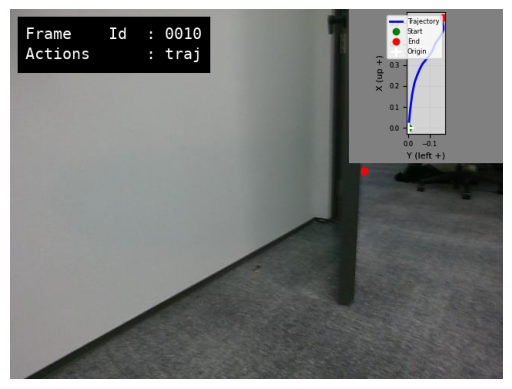

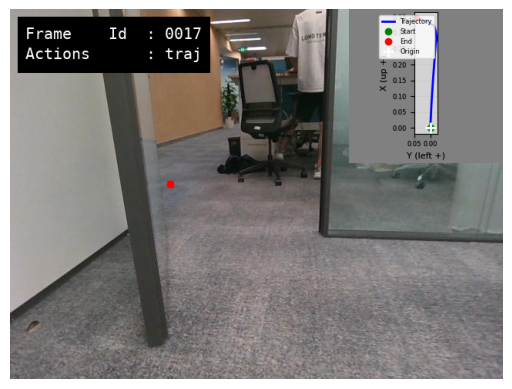

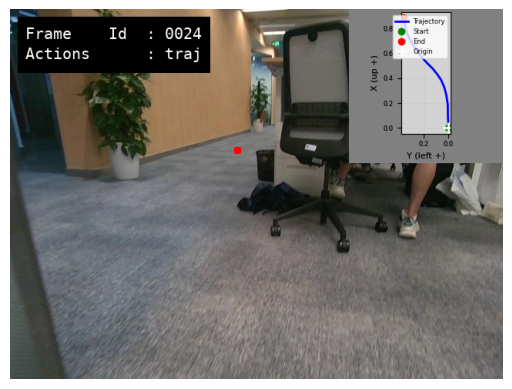

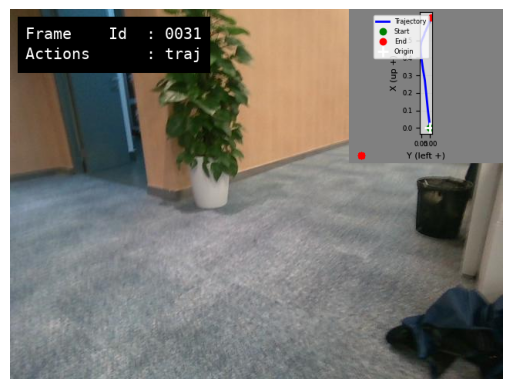

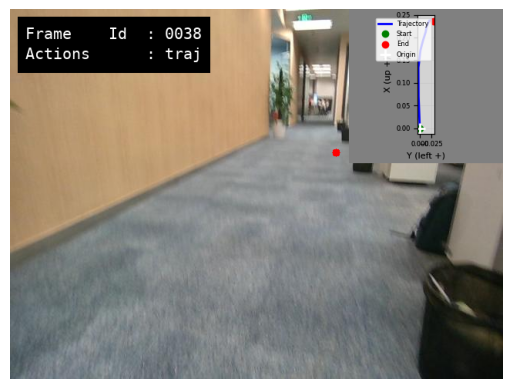

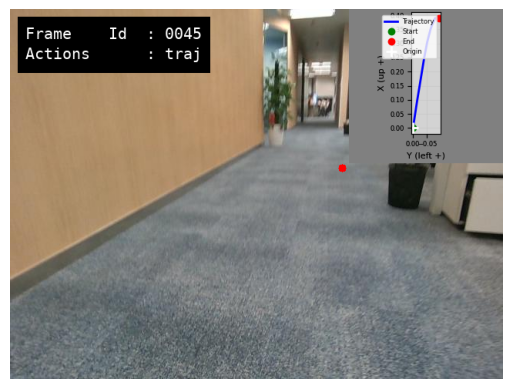

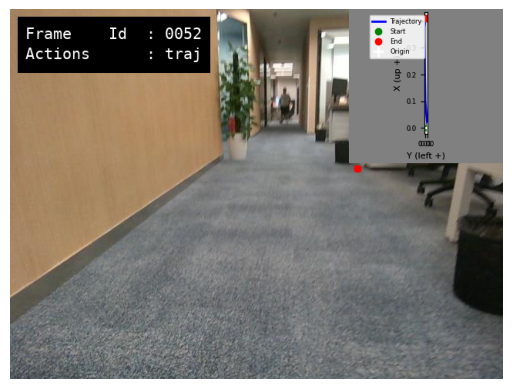

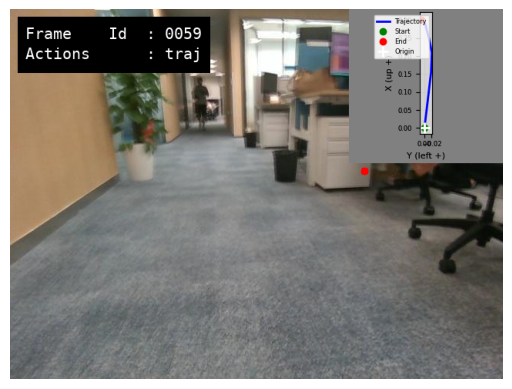

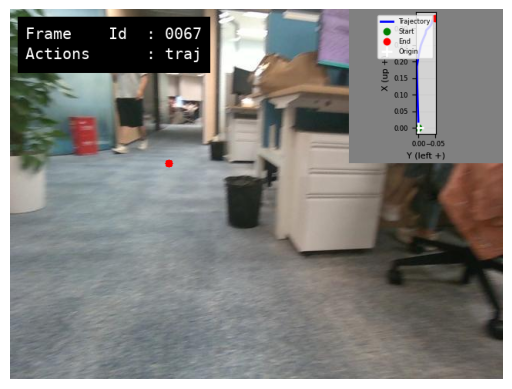

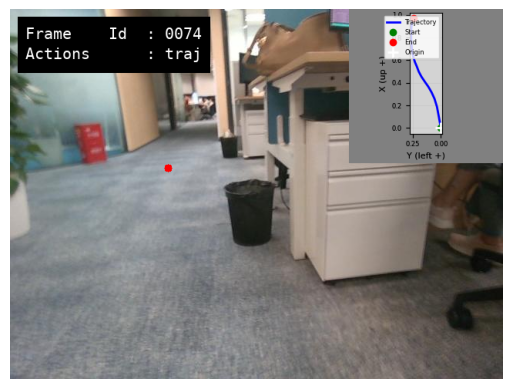

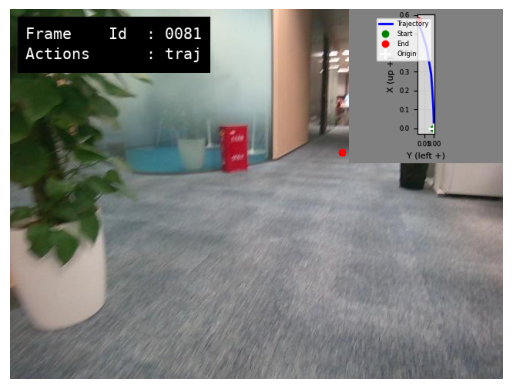

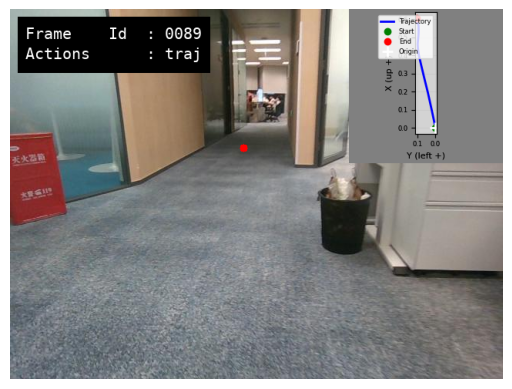

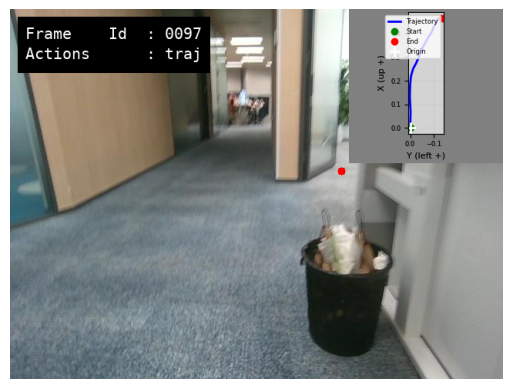

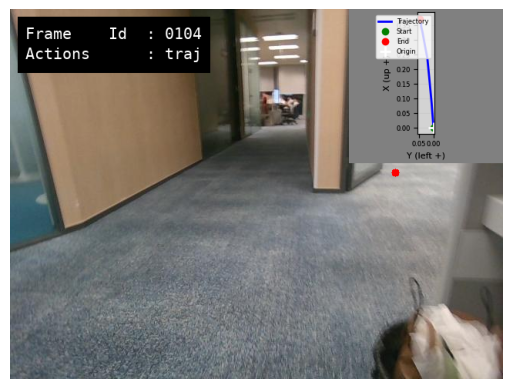

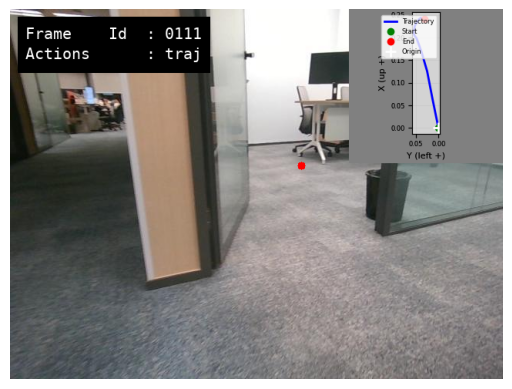

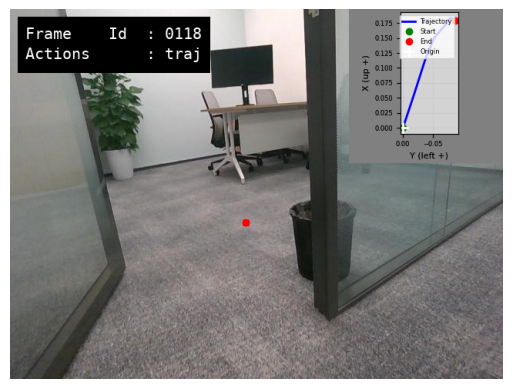

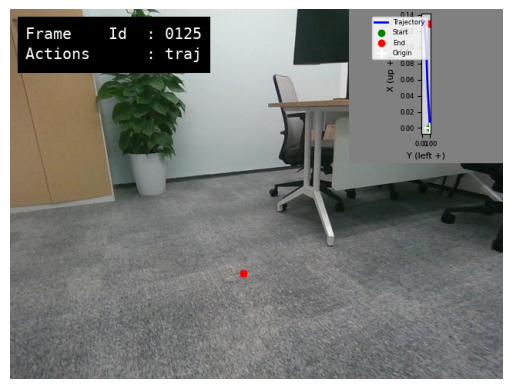

In [8]:

import glob
from PIL import Image
import matplotlib.pyplot as plt

for img_path in sorted(glob.glob(f'{save_dir}/*_annotated.png')):
    plt.imshow(Image.open(img_path))
    plt.axis('off')
    plt.show()